## Predicting Flight Delay using Machine Learning and Deep Learning

In [ ]:
# download and install necessary libraries
!pip install scikeras
from scikeras.wrappers import KerasRegressor, KerasClassifier
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, matthews_corrcoef
from sklearn.metrics import roc_curve, roc_auc_score, cohen_kappa_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, VotingRegressor, VotingClassifier
from sklearn.ensemble import StackingRegressor, StackingClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 93.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


## DATA
The US flight data was sourced from [kaggle.com](https://www.kaggle.com/datasets/bordanova/2023-us-civil-flights-delay-meteo-and-aircraft) where 2023 US Avian Data was scraped from the Bureau of Transportation Statistics (BTS) website.
It comprises several datasets with feature data like “departure and arrival delays”, “weather information at each airport”, “associated airlines” and “airplane information”. The data has been pre filtered to only include Atlanta Airport as the Departure Airport since it has one of the largest entries in the original dataset

In [ ]:
# download the flight dataset for atlanta airport
!gdown 1Zpb1-7vw0oZUXKo52uHri5Uc_upgXUAO

# download the weather data for atlanta airport
!gdown 1YJocyjUWYdSyVOtUj6NI3_pHEYw9Iv-u

Downloading...
From: https://drive.google.com/uc?id=1Zpb1-7vw0oZUXKo52uHri5Uc_upgXUAO
To: /content/US_Atlanta_Airport_Data.csv
100% 58.3M/58.3M [00:01<00:00, 34.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YJocyjUWYdSyVOtUj6NI3_pHEYw9Iv-u
To: /content/Weather_Atlanta_Data.csv
100% 22.1k/22.1k [00:00<00:00, 38.0MB/s]


In [ ]:
# read in the flight data without weather details
us_flight_data = pd.read_csv("US_Atlanta_Airport_Data.csv")
us_flight_data.shape

(332935, 25)

In [ ]:
# randomly show 10 row samples of the flight data
us_flight_data.sample(10)

,Unnamed: 0,FlightDate,Day_Of_Week,Airline,Tail_Number,Dep_Airport,Dep_CityName,DepTime_label,Dep_Delay,Dep_Delay_Tag,...,Flight_Duration,Distance_type,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,Manufacturer,Model,Aicraft_age
283410,5763156,2023-11-16,4,Delta Air Lines Inc,N960DZ,ATL,"Atlanta, GA",Evening,-8,0,...,85,Short Haul >1500Mi,0,0,0,0,0,BOEING,737 NG,10
243009,4724826,2023-09-18,1,Spirit Air Lines,N523NK,ATL,"Atlanta, GA",Morning,79,1,...,257,Medium Haul <3000Mi,0,0,72,0,0,AIRBUS,A319,18
46517,813286,2023-02-12,7,Southwest Airlines Co.,N8618N,ATL,"Atlanta, GA",Evening,32,1,...,71,Short Haul >1500Mi,23,0,0,0,0,BOEING,737 NG,11
31991,666059,2023-02-17,5,Delta Air Lines Inc,N981AT,ATL,"Atlanta, GA",Evening,70,1,...,111,Short Haul >1500Mi,60,0,0,0,0,BOEING,717,22
49981,996584,2023-02-20,1,United Air Lines Inc.,N77258,ATL,"Atlanta, GA",Afternoon,44,1,...,137,Short Haul >1500Mi,41,0,0,0,0,BOEING,737 NG,24
285031,5770465,2023-11-18,6,Delta Air Lines Inc,N590NW,ATL,"Atlanta, GA",Morning,-1,0,...,254,Medium Haul <3000Mi,0,0,0,0,0,BOEING,757,21
140054,2872346,2023-06-11,7,Delta Air Lines Inc,N3761R,ATL,"Atlanta, GA",Evening,12,1,...,106,Short Haul >1500Mi,12,0,9,0,0,BOEING,737 NG,23
138515,2864947,2023-06-04,7,Delta Air Lines Inc,N883DN,ATL,"Atlanta, GA",Evening,30,1,...,74,Short Haul >1500Mi,0,0,0,0,24,BOEING,737 NG,7
141036,2876604,2023-06-22,4,Delta Air Lines Inc,N996AT,ATL,"Atlanta, GA",Afternoon,-3,0,...,40,Short Haul >1500Mi,0,0,0,0,0,BOEING,717,22
21451,264847,2023-01-06,5,Spirit Air Lines,N615NK,ATL,"Atlanta, GA",Afternoon,49,1,...,136,Short Haul >1500Mi,38,0,0,0,0,AIRBUS,A320,12


In [ ]:
# print the column names of the flight data
print(us_flight_data.columns)

Index(['Unnamed: 0', 'FlightDate', 'Day_Of_Week', 'Airline', 'Tail_Number',
       'Dep_Airport', 'Dep_CityName', 'DepTime_label', 'Dep_Delay',
       'Dep_Delay_Tag', 'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName',
       'Arr_Delay', 'Arr_Delay_Type', 'Flight_Duration', 'Distance_type',
       'Delay_Carrier', 'Delay_Weather', 'Delay_NAS', 'Delay_Security',
       'Delay_LastAircraft', 'Manufacturer', 'Model', 'Aicraft_age'],
      dtype='object')


In [ ]:
# drop the Unnamed index, it is the former index
us_flight_data.drop(['Unnamed: 0'],axis=1, inplace=True)

In [ ]:
# check the general information about the data
us_flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332935 entries, 0 to 332934
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   FlightDate          332935 non-null  object
 1   Day_Of_Week         332935 non-null  int64 
 2   Airline             332935 non-null  object
 3   Tail_Number         332935 non-null  object
 4   Dep_Airport         332935 non-null  object
 5   Dep_CityName        332935 non-null  object
 6   DepTime_label       332935 non-null  object
 7   Dep_Delay           332935 non-null  int64 
 8   Dep_Delay_Tag       332935 non-null  int64 
 9   Dep_Delay_Type      332935 non-null  object
 10  Arr_Airport         332935 non-null  object
 11  Arr_CityName        332935 non-null  object
 12  Arr_Delay           332935 non-null  int64 
 13  Arr_Delay_Type      332935 non-null  object
 14  Flight_Duration     332935 non-null  int64 
 15  Distance_type       332935 non-null  object
 16  De

In [ ]:
# check for duplicates
us_flight_data.duplicated().sum()

1

In [ ]:
# whats the row that is duplicated?
us_flight_data[us_flight_data.duplicated()]

,FlightDate,Day_Of_Week,Airline,Tail_Number,Dep_Airport,Dep_CityName,DepTime_label,Dep_Delay,Dep_Delay_Tag,Dep_Delay_Type,...,Flight_Duration,Distance_type,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,Manufacturer,Model,Aicraft_age
132696,2023-05-19,5,Skywest Airlines Inc.,N803SK,ATL,"Atlanta, GA",Afternoon,-4,0,Low <5min,...,69,Short Haul >1500Mi,0,0,0,0,0,CANADAIR REGIONAL JET,CRJ,18


In [ ]:
# drop the duplilcated row
us_flight_data.drop(132696, inplace=True)

In [ ]:
# check if there are still duplicates
us_flight_data.duplicated().sum()

0

In [ ]:
# check for missing values
us_flight_data.isnull().sum()

,0
FlightDate,0
Day_Of_Week,0
Airline,0
Tail_Number,0
Dep_Airport,0
Dep_CityName,0
DepTime_label,0
Dep_Delay,0
Dep_Delay_Tag,0
Dep_Delay_Type,0


## Exploring the Flight Data

In [ ]:
# check the overview of the data
us_flight_data.describe()

,Day_Of_Week,Dep_Delay,Dep_Delay_Tag,Arr_Delay,Flight_Duration,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,Aicraft_age
count,332934.00000,332934.000000,332934.000000,332934.000000,332934.000000,332934.000000,332934.000000,332934.000000,332934.000000,332934.000000,332934.000000
mean,3.98075,11.485490,0.386893,5.760559,120.595938,5.733851,0.693549,2.142199,0.019800,3.429833,15.693179
std,2.00155,43.723023,0.487040,45.653911,65.320990,30.258805,13.190093,13.294457,1.207157,20.955176,8.929155
min,1.00000,-34.000000,0.000000,-68.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.00000,-4.000000,0.000000,-13.000000,79.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
50%,4.00000,-1.000000,0.000000,-5.000000,105.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000
75%,6.00000,9.000000,1.000000,8.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000
max,7.00000,3221.000000,1.000000,3237.000000,719.000000,3221.000000,1014.000000,1300.000000,323.000000,2216.000000,57.000000


Based on the descriptive view, it looks like there are outliers in the data. This will be investigated further. The Dep_Delay(delay in minutes) and the Dep_Delay_Tag are the targets of interest. Use a box-plot to identify outliers in the Dep_Delay and barplot to identify imbalance in the delay tag

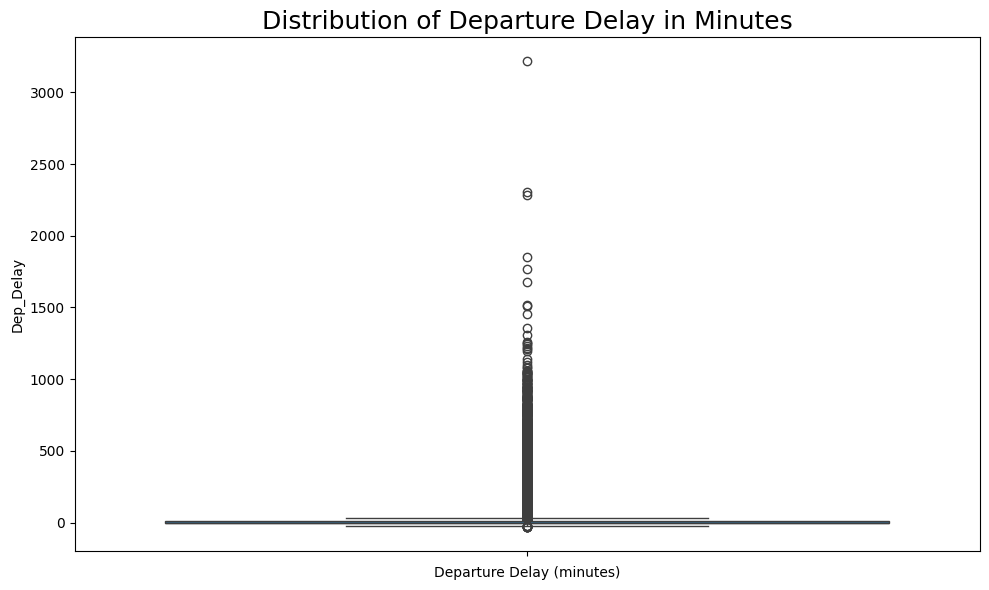

In [ ]:
# Distribution of delay in minutes to identify outliers if any
plt.figure(figsize=(10, 6))
ax = sns.boxplot(y='Dep_Delay', data=us_flight_data)
# ax = us_flight_data["Dep_Delay"].plot(kind="box")
plt.title('Distribution of Departure Delay in Minutes', fontsize=18)
plt.xlabel('Departure Delay (minutes)')
plt.tight_layout()
plt.show()

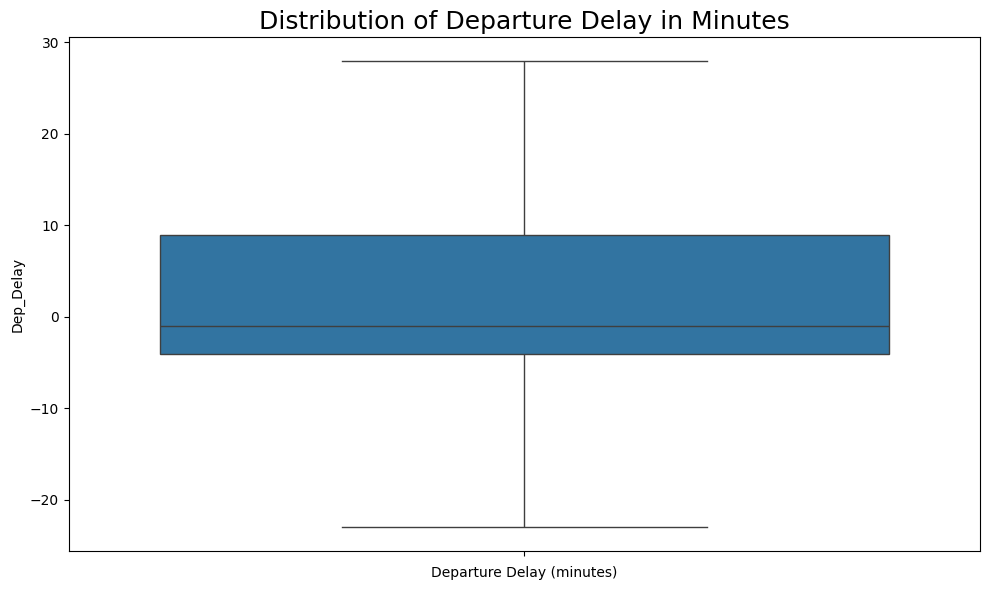

In [ ]:
# Distribution of delay in minutes without the outliers
plt.figure(figsize=(10, 6))
ax = sns.boxplot(y='Dep_Delay', data=us_flight_data, showfliers=False)
# ax = us_flight_data["Dep_Delay"].plot(kind="box")
plt.title('Distribution of Departure Delay in Minutes', fontsize=18)
plt.xlabel('Departure Delay (minutes)')
plt.tight_layout()
plt.show()

In [ ]:
# check instances were the departure delay in minutes where negative
us_flight_data.query("Dep_Delay < 0")

,FlightDate,Day_Of_Week,Airline,Tail_Number,Dep_Airport,Dep_CityName,DepTime_label,Dep_Delay,Dep_Delay_Tag,Dep_Delay_Type,...,Flight_Duration,Distance_type,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,Manufacturer,Model,Aicraft_age
0,2023-01-09,1,Endeavor Air,N181GJ,ATL,"Atlanta, GA",Afternoon,-3,0,Low <5min,...,67,Short Haul >1500Mi,0,0,0,0,0,CANADAIR REGIONAL JET,CRJ,16
1,2023-01-10,2,Endeavor Air,N937XJ,ATL,"Atlanta, GA",Afternoon,-5,0,Low <5min,...,69,Short Haul >1500Mi,0,0,0,0,0,CANADAIR REGIONAL JET,CRJ,16
2,2023-01-11,3,Endeavor Air,N604LR,ATL,"Atlanta, GA",Afternoon,-2,0,Low <5min,...,71,Short Haul >1500Mi,0,0,0,0,0,CANADAIR REGIONAL JET,CRJ,16
4,2023-01-13,5,Endeavor Air,N324PQ,ATL,"Atlanta, GA",Afternoon,-3,0,Low <5min,...,71,Short Haul >1500Mi,0,0,0,0,0,CANADAIR REGIONAL JET,CRJ,10
5,2023-01-14,6,Endeavor Air,N316PQ,ATL,"Atlanta, GA",Afternoon,-1,0,Low <5min,...,73,Short Haul >1500Mi,0,0,0,0,0,CANADAIR REGIONAL JET,CRJ,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332925,2023-12-30,6,JetBlue Airways,N3125J,ATL,"Atlanta, GA",Morning,-7,0,Low <5min,...,137,Short Haul >1500Mi,0,0,0,0,0,AIRBUS,A220,1
332928,2023-12-30,6,JetBlue Airways,N589JB,ATL,"Atlanta, GA",Afternoon,-9,0,Low <5min,...,125,Short Haul >1500Mi,0,0,0,0,0,AIRBUS,A320,20
332930,2023-12-31,7,JetBlue Airways,N559JB,ATL,"Atlanta, GA",Morning,-6,0,Low <5min,...,109,Short Haul >1500Mi,0,0,0,0,0,AIRBUS,A320,22
332931,2023-12-31,7,JetBlue Airways,N228JB,ATL,"Atlanta, GA",Afternoon,-8,0,Low <5min,...,129,Short Haul >1500Mi,0,0,0,0,0,EMBRAER,190/195,18


There are 182082 rows for negative entries. It might indicate that rather than delays, flights departed earlier. Check how many there are for positive entries.

In [ ]:
# check instances were the departure delay in minutes where positive
us_flight_data.query("Dep_Delay >= 0")

,FlightDate,Day_Of_Week,Airline,Tail_Number,Dep_Airport,Dep_CityName,DepTime_label,Dep_Delay,Dep_Delay_Tag,Dep_Delay_Type,...,Flight_Duration,Distance_type,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,Manufacturer,Model,Aicraft_age
3,2023-01-12,4,Endeavor Air,N371CA,ATL,"Atlanta, GA",Afternoon,16,1,Medium >15min,...,71,Short Haul >1500Mi,0,0,0,0,0,CANADAIR REGIONAL JET,CRJ,21
11,2023-01-20,5,Endeavor Air,N292PQ,ATL,"Atlanta, GA",Afternoon,0,0,Low <5min,...,69,Short Haul >1500Mi,0,0,0,0,0,CANADAIR REGIONAL JET,CRJ,11
16,2023-01-25,3,Endeavor Air,N313PQ,ATL,"Atlanta, GA",Afternoon,10,1,Low <5min,...,77,Short Haul >1500Mi,0,0,0,0,0,CANADAIR REGIONAL JET,CRJ,10
17,2023-01-26,4,Endeavor Air,N146PQ,ATL,"Atlanta, GA",Afternoon,11,1,Low <5min,...,68,Short Haul >1500Mi,0,0,0,0,0,CANADAIR REGIONAL JET,CRJ,17
22,2023-01-31,2,Endeavor Air,N314PQ,ATL,"Atlanta, GA",Afternoon,36,1,Medium >15min,...,64,Short Haul >1500Mi,0,0,0,0,24,CANADAIR REGIONAL JET,CRJ,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332926,2023-12-30,6,JetBlue Airways,N273JB,ATL,"Atlanta, GA",Afternoon,7,1,Low <5min,...,151,Short Haul >1500Mi,7,0,9,0,0,EMBRAER,190/195,17
332927,2023-12-30,6,JetBlue Airways,N594JB,ATL,"Atlanta, GA",Afternoon,29,1,Medium >15min,...,130,Short Haul >1500Mi,14,0,21,0,15,AIRBUS,A320,20
332929,2023-12-30,6,JetBlue Airways,N608JB,ATL,"Atlanta, GA",Morning,0,0,Low <5min,...,133,Short Haul >1500Mi,0,0,0,0,0,AIRBUS,A320,19
332933,2023-12-31,7,JetBlue Airways,N323JB,ATL,"Atlanta, GA",Afternoon,13,1,Low <5min,...,127,Short Haul >1500Mi,0,0,0,0,0,EMBRAER,190/195,14


Negative instances are more than positive instances. Let's focus on delays, so that if there is no delay, it will be 0 minutes of delay. Update the negative entries to zero

In [ ]:
# update negative entries of delay in minutes to 0
us_flight_data["Dep_Delay"] = us_flight_data["Dep_Delay"].apply(lambda x: 0 if x < 0 else x)

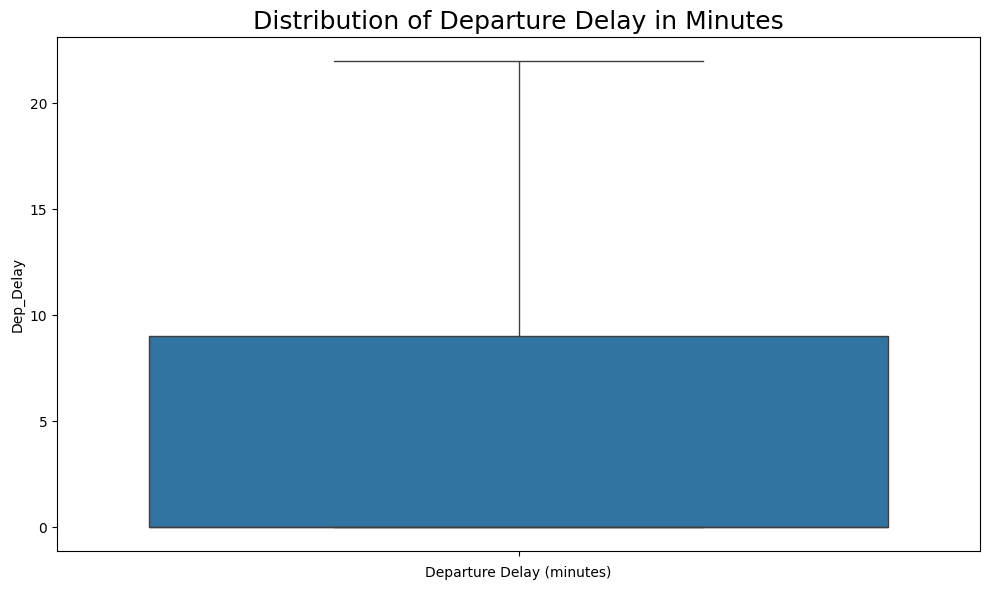

In [ ]:
# use boxplot to check the distribution of delay in minutes without the outliers
plt.figure(figsize=(10, 6))
ax = sns.boxplot(y='Dep_Delay', data=us_flight_data, showfliers=False)
# ax = us_flight_data["Dep_Delay"].plot(kind="box")
plt.title('Distribution of Departure Delay in Minutes', fontsize=18)
plt.xlabel('Departure Delay (minutes)')
plt.tight_layout()
plt.show()

In [ ]:
# check the shape of the flight data before handling outliers
us_flight_data.shape

(332934, 24)

In [ ]:
# handle outliers using iqr
q1 = us_flight_data['Dep_Delay'].quantile(0.25) # upper limits
q3 = us_flight_data['Dep_Delay'].quantile(0.75) # lower limits
iqr = q3 - q1
lower = q3 - 1.5*iqr
upper = q3 + 1.5*iqr
upper_range = np.where(us_flight_data['Dep_Delay'] >= upper)[0]
lower_range = np.where(us_flight_data['Dep_Delay'] <= lower)[0]

upper_lower_ind = np.concatenate((upper_range, lower_range))
us_flight_data = us_flight_data.drop(upper_lower_ind)

# check the shape after handling outliers
us_flight_data.shape

(280369, 24)

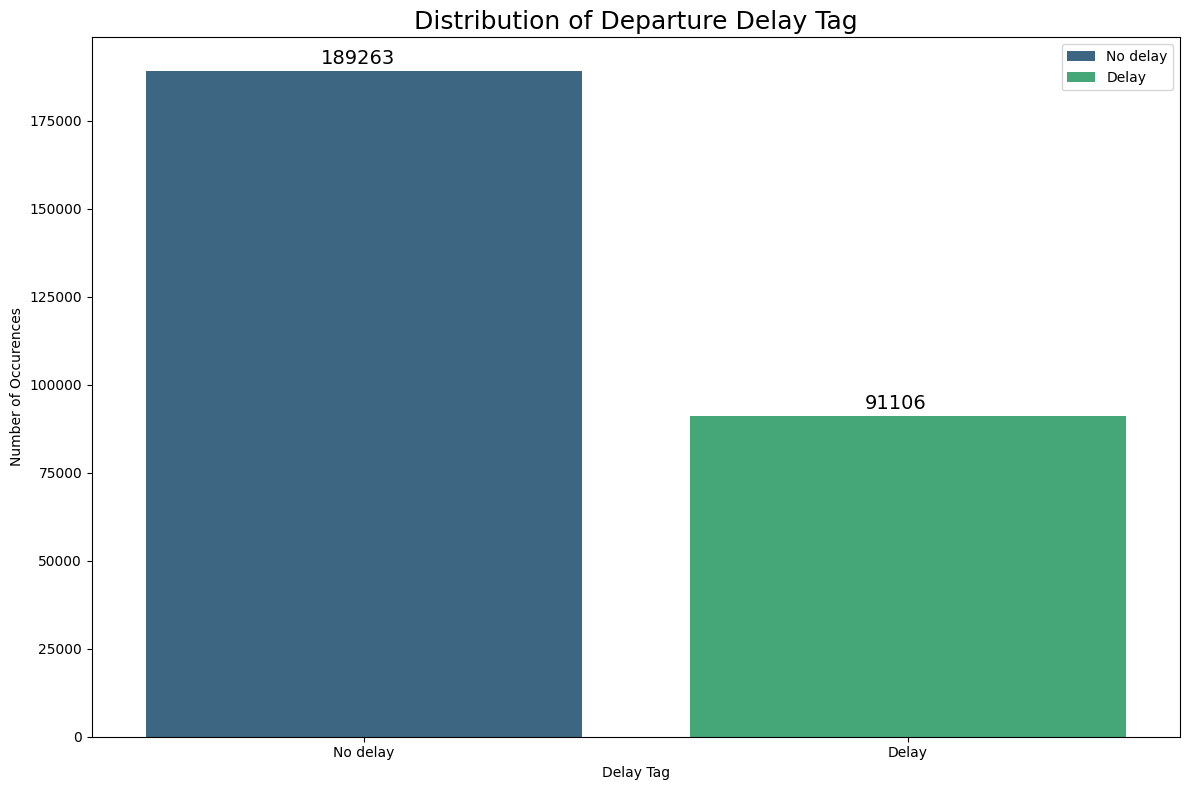

In [ ]:
# Distribution of the delay tag
plt.figure(figsize=(12, 8))
dep_delay_dist = sns.countplot(x='Dep_Delay_Tag', data=us_flight_data, palette='viridis', hue='Dep_Delay_Tag', legend=False)

# put the ylabels on top of the bar
for p in dep_delay_dist.patches:
    dep_delay_dist.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2.5, p.get_height()), fontsize=14, xytext=(0, 5),
                        textcoords='offset points')

plt.title('Distribution of Departure Delay Tag', fontsize=18)
plt.xlabel('Delay Tag')
plt.xticks(ticks=[0, 1], labels=["No delay", "Delay"], rotation=0)
plt.ylabel('Number of Occurences')
plt.tight_layout()
plt.legend(['No delay', 'Delay'], loc='upper right')
plt.show()

There is imbalance in the departure delay tag. This will be factored in when spliting the data for training and testing

In [ ]:
# check out the value counts for the airlines to identify possible bias
us_flight_data['Airline'].value_counts()

,count
Airline,
Delta Air Lines Inc,186443
Southwest Airlines Co.,29794
Endeavor Air,18595
Spirit Air Lines,10103
Skywest Airlines Inc.,8231
American Airlines Inc.,7171
United Air Lines Inc.,6564
Frontier Airlines Inc.,6559
JetBlue Airways,2508


There is imbalance in the number of entries for the airlines. Check their delay proportion

In [ ]:
# get the proportion of delayed flights per airline
airline_delay_prop = us_flight_data.groupby('Airline')["Dep_Delay_Tag"].mean()
airline_delay_prop = airline_delay_prop.sort_values(ascending=False) * 100
airline_delay_prop

,Dep_Delay_Tag
Airline,
Southwest Airlines Co.,49.969793
Frontier Airlines Inc.,49.397774
Spirit Air Lines,43.600911
JetBlue Airways,40.869219
United Air Lines Inc.,36.273614
Alaska Airlines Inc.,34.532374
American Eagle Airlines Inc.,33.816425
Delta Air Lines Inc,30.927951
PSA Airlines,25.697786


In [ ]:
# create a dataframe for the proportion of delays for each airline
airline_delay_df = pd.DataFrame()
airline_delay_df["Airline"] = airline_delay_prop.index
airline_delay_df["Delay Proportion"] = airline_delay_prop.values

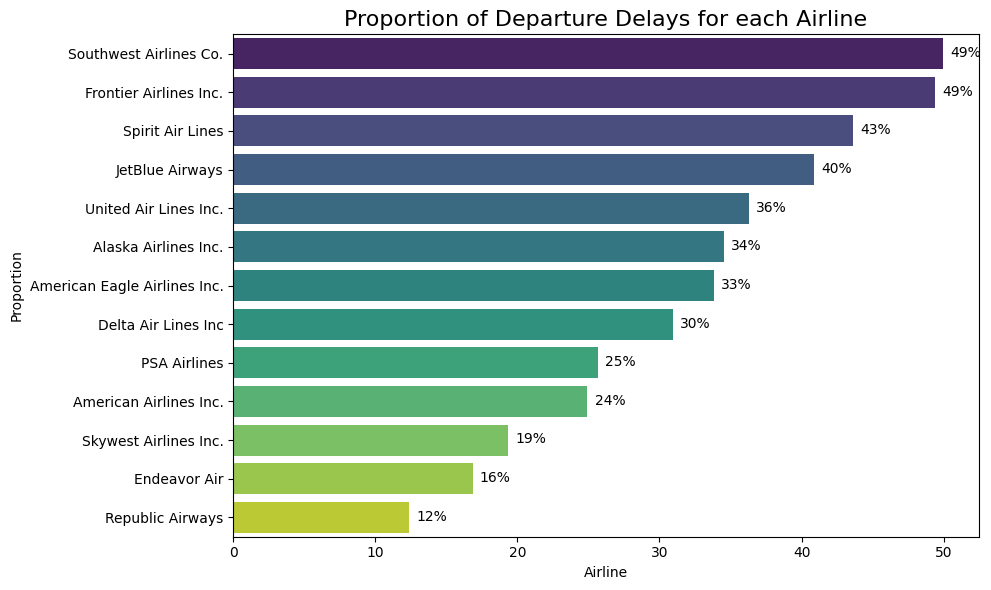

In [ ]:
# Distribution of the delay proportion for each airline
plt.figure(figsize=(10, 6))
airline_delay_dist = sns.barplot(x='Delay Proportion', y='Airline', data=airline_delay_df, palette='viridis', hue='Airline', legend=False)

# put the ylabels on top of the bar
for p in airline_delay_dist.patches:
    airline_delay_dist.annotate(f'{int(p.get_width())}%', (p.get_width()+0.5, p.get_y() + p.get_height() / 1.2), fontsize=10, xytext=(0, 5),
                        textcoords='offset points')

plt.title('Proportion of Departure Delays for each Airline', fontsize=16)
plt.xlabel('Airline')
# plt.xticks(ticks=range(13), labels=airline_delay_df["Airline"], rotation=90)
plt.ylabel('Proportion')
plt.tight_layout()
# plt.legend()
plt.show()

Most airlines have below 50% of their records showing that there were delays in Departure.

In [ ]:
# are there flights for a full year present?
us_flight_data['FlightDate'].nunique()

365

In [ ]:
# how many flights go out on certain days
us_flight_data['FlightDate'].value_counts()

,count
FlightDate,
2023-11-06,955
2023-10-02,946
2023-10-16,944
2023-11-22,944
2023-11-13,941
...,...
2023-08-06,399
2023-03-26,372
2023-01-11,364


In [ ]:
# checking the data types of the columns
us_flight_data.dtypes

,0
FlightDate,object
Day_Of_Week,int64
Airline,object
Tail_Number,object
Dep_Airport,object
Dep_CityName,object
DepTime_label,object
Dep_Delay,int64
Dep_Delay_Tag,int64
Dep_Delay_Type,object


In [ ]:
# change the datetime column from object to datetime
us_flight_data['FlightDate'] = pd.to_datetime(us_flight_data['FlightDate'])

In [ ]:
#check if the dtype has changed?
us_flight_data['FlightDate'].dtype

dtype('<M8[ns]')

In [ ]:
# check if there's a relationship between flight duration and 'dep_delay'
us_flight_data[['Flight_Duration','Dep_Delay']].corr()

,Flight_Duration,Dep_Delay
Flight_Duration,1.000000,0.022873
Dep_Delay,0.022873,1.000000


Flight duration may not have a big influence on delay tiimes

In [ ]:
# what about aircraft age?
us_flight_data[['Aicraft_age','Dep_Delay']].corr()

,Aicraft_age,Dep_Delay
Aicraft_age,1.000000,-0.009831
Dep_Delay,-0.009831,1.000000


In [ ]:
#what are the aircraft models value counts?
us_flight_data['Model'].value_counts()

,count
Model,
737 NG,85529
A321,46251
757,40081
717,36018
CRJ,27851
A320,26126
A319,11829
170/175,2403
767,1902


In [ ]:
#what about aircraft model by avg delay?
us_flight_data.groupby('Model')['Dep_Delay'].mean()

,Dep_Delay
Model,
170/175,5.140241
190/195,14.140200
717,4.932145
737,9.347222
737 NG,7.703937
737 NG/MAX,7.594017
757,8.645767
767,12.213985
A220,10.352941


In [ ]:
# separate the flightdate column into day and month columns
us_flight_data['Month'] = us_flight_data['FlightDate'].dt.month
us_flight_data['Day'] = us_flight_data['FlightDate'].dt.day
# us_flight_data['Day_of_week'] = us_flight_data['FlightDate'].dt.day_of_week

In [ ]:
#checking if any months show a bias
us_flight_data['Month'].value_counts()

,count
Month,
10,26536
11,25393
12,25099
9,24991
5,24498
8,22833
3,22675
7,22178
4,22121


In [ ]:
#finding the average delay by month
us_flight_data.groupby('Month')['Dep_Delay'].mean()

,Dep_Delay
Month,
1,2.436396
2,2.064521
3,2.639515
4,2.810316
5,2.918238
6,18.290284
7,18.375417
8,16.300311
9,8.832780


<Axes: xlabel='Month'>

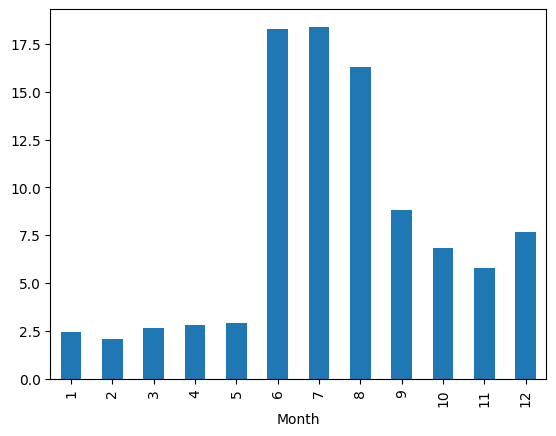

In [ ]:
#plotting the chart of avg delay by month
avg_by_month = us_flight_data.groupby('Month')['Dep_Delay'].mean()
avg_by_month.plot(kind = 'bar')

<Axes: xlabel='Day'>

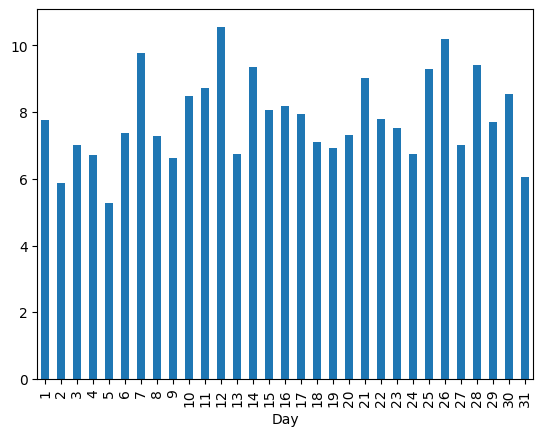

In [ ]:
#plotting the chart of avg of delay by day of month
avg_by_day = us_flight_data.groupby('Day')['Dep_Delay'].mean()
avg_by_day.plot(kind = 'bar')

<Axes: xlabel='Day_Of_Week'>

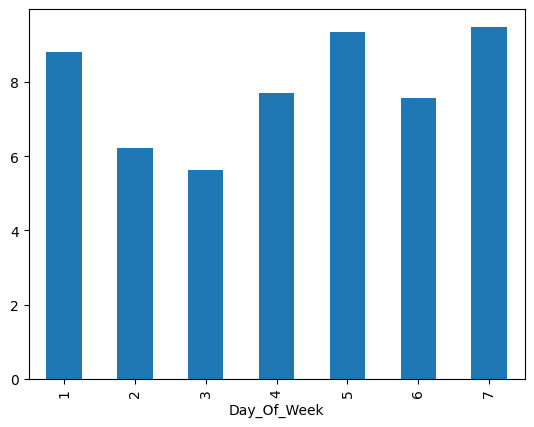

In [ ]:
#plotting the chart of avg of delay by day of week
avg_by_dweek = us_flight_data.groupby('Day_Of_Week')['Dep_Delay'].mean()
avg_by_dweek.plot(kind='bar')

<Axes: xlabel='DepTime_label'>

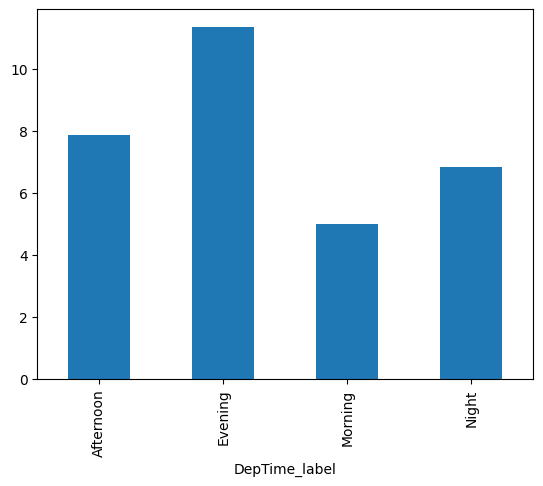

In [ ]:
#plotting the chart of avg of delay by time of day
avg_time_day = us_flight_data.groupby('DepTime_label')['Dep_Delay'].mean()
avg_time_day.plot(kind='bar')

In [ ]:
#based on delay type, how many are there?
us_flight_data['Dep_Delay_Type'].value_counts()

,count
Dep_Delay_Type,
Low <5min,245536
Medium >15min,26650
Hight >60min,8183


In [ ]:
# check for correlation in the flight data
us_flight_data.select_dtypes(include=["int", "float"]).corr()

,Day_Of_Week,Dep_Delay,Dep_Delay_Tag,Arr_Delay,Flight_Duration,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,Aicraft_age,Month,Day
Day_Of_Week,1.000000,0.020168,0.035919,0.029284,0.012505,0.008525,0.008360,0.021218,0.003944,0.016098,-0.003055,0.018994,-0.007848
Dep_Delay,0.020168,1.000000,0.376114,0.937473,0.022873,0.765910,0.270458,0.233965,0.028403,0.563922,-0.009831,0.071117,0.011020
Dep_Delay_Tag,0.035919,0.376114,1.000000,0.396489,0.085523,0.203438,0.056552,0.123392,0.018458,0.175424,-0.038024,0.001917,0.015132
Arr_Delay,0.029284,0.937473,0.396489,1.000000,0.051777,0.723106,0.260407,0.381570,0.026984,0.531741,0.001748,0.044692,0.008176
Flight_Duration,0.012505,0.022873,0.085523,0.051777,1.000000,0.013564,0.003716,0.117053,0.003802,0.009118,-0.231366,-0.002086,-0.000968
Delay_Carrier,0.008525,0.765910,0.203438,0.723106,0.013564,1.000000,0.005050,0.044356,-0.000210,0.070862,0.010642,0.054572,0.005744
Delay_Weather,0.008360,0.270458,0.056552,0.260407,0.003716,0.005050,1.000000,0.027578,0.000700,0.021125,0.004756,0.012497,-0.000848
Delay_NAS,0.021218,0.233965,0.123392,0.381570,0.117053,0.044356,0.027578,1.000000,0.001815,0.044606,-0.012430,0.003440,0.003969
Delay_Security,0.003944,0.028403,0.018458,0.026984,0.003802,-0.000210,0.000700,0.001815,1.000000,0.005597,-0.001145,0.007620,0.000567
Delay_LastAircraft,0.016098,0.563922,0.175424,0.531741,0.009118,0.070862,0.021125,0.044606,0.005597,1.000000,-0.024598,0.043831,0.008431


Arr_Delay is strongly correlated with Dep_Delay. It will eventually be dropped as this analysis focuses on departure delay.

In [ ]:
# read in the weather data
weather_data = pd.read_csv("Weather_Atlanta_Data.csv")
weather_data.shape

(365, 11)

In [ ]:
# look into the weather data
weather_data.head()

,Unnamed: 0,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,airport_id
0,7665,2023-01-01,14.1,8.9,21.1,0.0,0.0,336.0,3.7,1019.0,ATL
1,7666,2023-01-02,13.2,6.1,18.3,9.4,0.0,13.0,1.6,1021.5,ATL
2,7667,2023-01-03,18.3,13.9,21.1,31.1,0.0,183.0,8.5,1016.4,ATL
3,7668,2023-01-04,16.4,8.3,20.6,24.4,0.0,228.0,9.5,1013.4,ATL
4,7669,2023-01-05,10.4,5.0,16.7,0.0,0.0,293.0,8.0,1019.0,ATL


In [ ]:
#dropping the unnamed column
weather_data.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
# the "time" column looks like the date
# rename the time column to "Date"
weather_data = weather_data.rename(columns={"time":"Date"})
weather_data.head()

,Date,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,airport_id
0,2023-01-01,14.1,8.9,21.1,0.0,0.0,336.0,3.7,1019.0,ATL
1,2023-01-02,13.2,6.1,18.3,9.4,0.0,13.0,1.6,1021.5,ATL
2,2023-01-03,18.3,13.9,21.1,31.1,0.0,183.0,8.5,1016.4,ATL
3,2023-01-04,16.4,8.3,20.6,24.4,0.0,228.0,9.5,1013.4,ATL
4,2023-01-05,10.4,5.0,16.7,0.0,0.0,293.0,8.0,1019.0,ATL


In [ ]:
# check the weather_data info
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        365 non-null    object 
 1   tavg        365 non-null    float64
 2   tmin        365 non-null    float64
 3   tmax        365 non-null    float64
 4   prcp        365 non-null    float64
 5   snow        365 non-null    float64
 6   wdir        365 non-null    float64
 7   wspd        365 non-null    float64
 8   pres        365 non-null    float64
 9   airport_id  365 non-null    object 
dtypes: float64(8), object(2)
memory usage: 28.6+ KB


In [ ]:
# update the "Date" column type to "datetime"
weather_data['Date'] = pd.to_datetime(weather_data['Date'])

In [ ]:
# drop the airport_id column, the entries are all for atlanta airport
weather_data.drop(columns=["airport_id"], inplace=True)
weather_data

,Date,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres
0,2023-01-01,14.1,8.9,21.1,0.0,0.0,336.0,3.7,1019.0
1,2023-01-02,13.2,6.1,18.3,9.4,0.0,13.0,1.6,1021.5
2,2023-01-03,18.3,13.9,21.1,31.1,0.0,183.0,8.5,1016.4
3,2023-01-04,16.4,8.3,20.6,24.4,0.0,228.0,9.5,1013.4
4,2023-01-05,10.4,5.0,16.7,0.0,0.0,293.0,8.0,1019.0
...,...,...,...,...,...,...,...,...,...
360,2023-12-27,10.8,8.3,13.3,0.0,0.0,270.0,6.9,1012.9
361,2023-12-28,7.3,2.8,12.2,0.0,0.0,309.0,6.8,1011.7
362,2023-12-29,4.4,1.7,6.7,0.1,0.0,268.0,11.9,1013.9
363,2023-12-30,4.3,1.1,8.3,0.0,0.0,294.0,10.6,1018.4


In [ ]:
#look at the description of the numeric data
weather_data.select_dtypes(exclude="datetime").describe()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres
count,365.000000,365.000000,365.000000,365.000000,365.0,365.000000,365.000000,365.000000
mean,17.487945,12.131781,23.226027,3.241918,0.0,206.642466,7.524658,1017.155068
std,6.998647,7.590001,7.159429,8.063315,0.0,133.554282,4.070444,5.379194
min,1.800000,-5.000000,6.100000,0.000000,0.0,0.000000,0.000000,1001.300000
25%,12.200000,6.700000,17.800000,0.000000,0.0,59.000000,4.600000,1013.400000
50%,18.400000,13.300000,23.900000,0.000000,0.0,270.000000,6.700000,1016.600000
75%,23.400000,18.900000,28.900000,1.500000,0.0,327.000000,9.700000,1020.400000
max,30.100000,25.600000,36.700000,71.300000,0.0,359.000000,22.200000,1036.500000


In [ ]:
#is the snow column only zeros?
weather_data['snow'].value_counts()

,count
snow,
0.0,365


In [ ]:
# drop the "snow" columns, it only contains zeros, no visibly change
weather_data.drop(columns=["snow"], inplace=True)

In [ ]:
# check for correlation in the weather data
weather_data.corr()

,Date,tavg,tmin,tmax,prcp,wdir,wspd,pres
Date,1.000000,0.085653,0.099360,0.097444,-0.155013,-0.105710,-0.177512,0.057203
tavg,0.085653,1.000000,0.958922,0.956111,-0.021117,0.025881,-0.184493,-0.516300
tmin,0.099360,0.958922,1.000000,0.849526,0.060634,0.015876,-0.076687,-0.549032
tmax,0.097444,0.956111,0.849526,1.000000,-0.092834,0.042705,-0.303105,-0.415449
prcp,-0.155013,-0.021117,0.060634,-0.092834,1.000000,-0.029453,0.284853,-0.197758
wdir,-0.105710,0.025881,0.015876,0.042705,-0.029453,1.000000,0.058137,-0.306707
wspd,-0.177512,-0.184493,-0.076687,-0.303105,0.284853,0.058137,1.000000,-0.253682
pres,0.057203,-0.516300,-0.549032,-0.415449,-0.197758,-0.306707,-0.253682,1.000000


The minimumm, maximum and average temperature are strongly correlated with one another. Only the average temperature will be used to avoid multi-colinearity issues. The minimum and maximum temperature per day will not be used as features for the model

In [ ]:
# prepare to merge the flight data with the weather data by renaming the "FlightDate" column to "Date"
us_flight_data = us_flight_data.rename(columns={"FlightDate":"Date"})

In [ ]:
# merge the atl data with the weather data
merged_flight_data = pd.merge(us_flight_data, weather_data, on=["Date"])
merged_flight_data.tail()

,Date,Day_Of_Week,Airline,Tail_Number,Dep_Airport,Dep_CityName,DepTime_label,Dep_Delay,Dep_Delay_Tag,Dep_Delay_Type,...,Aicraft_age,Month,Day,tavg,tmin,tmax,prcp,wdir,wspd,pres
280364,2023-12-03,7,JetBlue Airways,N239JB,ATL,"Atlanta, GA",Morning,55,1,Medium >15min,...,18,12,3,16.5,9.4,20.0,5.4,264.0,8.5,1012.1
280365,2023-12-03,7,JetBlue Airways,N3104J,ATL,"Atlanta, GA",Afternoon,20,1,Medium >15min,...,2,12,3,16.5,9.4,20.0,5.4,264.0,8.5,1012.1
280366,2023-12-03,7,JetBlue Airways,N789JB,ATL,"Atlanta, GA",Afternoon,166,1,Hight >60min,...,13,12,3,16.5,9.4,20.0,5.4,264.0,8.5,1012.1
280367,2023-12-03,7,JetBlue Airways,N554JB,ATL,"Atlanta, GA",Morning,0,0,Low <5min,...,22,12,3,16.5,9.4,20.0,5.4,264.0,8.5,1012.1
280368,2023-12-03,7,JetBlue Airways,N766JB,ATL,"Atlanta, GA",Morning,0,0,Low <5min,...,16,12,3,16.5,9.4,20.0,5.4,264.0,8.5,1012.1


In [ ]:
#checking the merged data columns
merged_flight_data.columns

Index(['Date', 'Day_Of_Week', 'Airline', 'Tail_Number', 'Dep_Airport',
       'Dep_CityName', 'DepTime_label', 'Dep_Delay', 'Dep_Delay_Tag',
       'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName', 'Arr_Delay',
       'Arr_Delay_Type', 'Flight_Duration', 'Distance_type', 'Delay_Carrier',
       'Delay_Weather', 'Delay_NAS', 'Delay_Security', 'Delay_LastAircraft',
       'Manufacturer', 'Model', 'Aicraft_age', 'Month', 'Day', 'tavg', 'tmin',
       'tmax', 'prcp', 'wdir', 'wspd', 'pres'],
      dtype='object')

In [ ]:
#checking the shape of the merged dataset
merged_flight_data.shape

(280369, 33)

<Axes: xlabel='Month'>

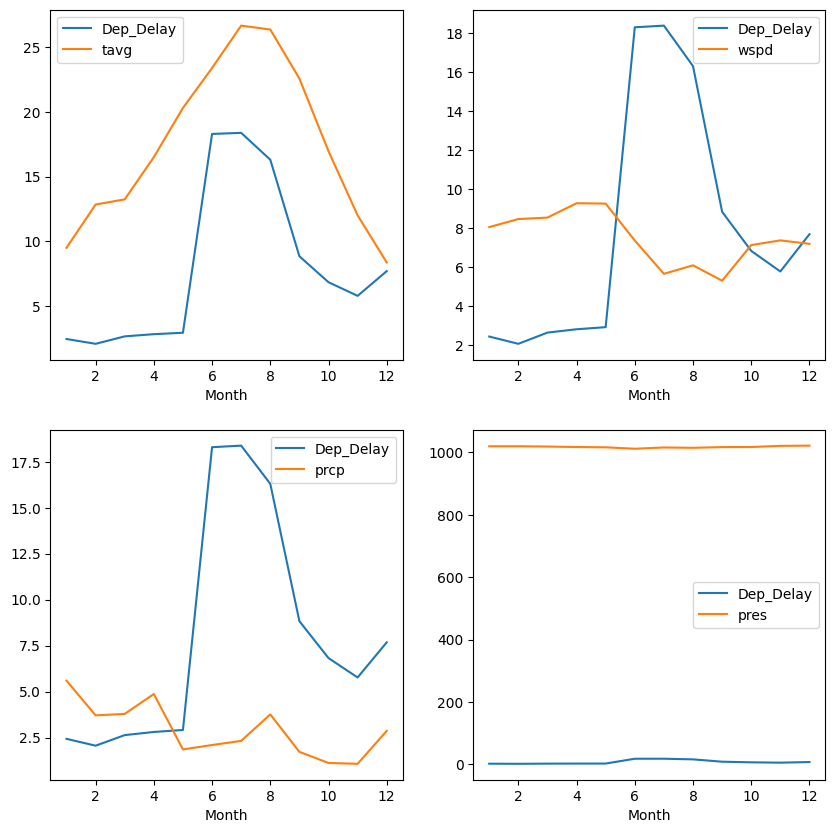

In [ ]:
#create subplots of the Delay in minutes compared with the weather conditions
fig=plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

avg_by_month_1 = merged_flight_data.groupby('Month')[['Dep_Delay','tavg']].mean()
avg_by_month_1.plot(kind = 'line', ax = ax1, figsize=(10,10))
avg_by_month_2 = merged_flight_data.groupby('Month')[['Dep_Delay','wspd']].mean()
avg_by_month_2.plot(kind = 'line', ax = ax2, figsize=(10,10))
avg_by_month_3 = merged_flight_data.groupby('Month')[['Dep_Delay','prcp']].mean()
avg_by_month_3.plot(kind = 'line', ax = ax3, figsize=(10,10))
avg_by_month_4 = merged_flight_data.groupby('Month')[['Dep_Delay','pres']].mean()
avg_by_month_4.plot(kind = 'line', ax = ax4, figsize=(10,10))


## Generating the Traditional Models

### Briefly Explore the Data Again

Choose the features that will make the X data by correlating with the target variable Y and drop what is not needed

In [ ]:
# check the info of the data
merged_flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280369 entries, 0 to 280368
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                280369 non-null  datetime64[ns]
 1   Day_Of_Week         280369 non-null  int64         
 2   Airline             280369 non-null  object        
 3   Tail_Number         280369 non-null  object        
 4   Dep_Airport         280369 non-null  object        
 5   Dep_CityName        280369 non-null  object        
 6   DepTime_label       280369 non-null  object        
 7   Dep_Delay           280369 non-null  int64         
 8   Dep_Delay_Tag       280369 non-null  int64         
 9   Dep_Delay_Type      280369 non-null  object        
 10  Arr_Airport         280369 non-null  object        
 11  Arr_CityName        280369 non-null  object        
 12  Arr_Delay           280369 non-null  int64         
 13  Arr_Delay_Type      280369 no

In [ ]:
# check the columns with datetime datatype
merged_flight_data.select_dtypes(include="datetime64")

,Date
0,2023-01-09
1,2023-01-09
2,2023-01-09
3,2023-01-09
4,2023-01-09
...,...
280364,2023-12-03
280365,2023-12-03
280366,2023-12-03
280367,2023-12-03


In [ ]:
# create a column on holidays
import holidays # library for date that are holidays
us_holidays = holidays.US()

# determine if a date is a holiday
def is_holiday(date):
    return int(date in us_holidays)

# create the holiday column
merged_flight_data["Holiday"] = merged_flight_data['Date'].apply(is_holiday)

The date column will not be used as a feature for the machine learning models. Add the Date to the list of columns to be dropped for the model

In [ ]:
# create a list of columns to dropped that will be updated
columns_to_drop = ["Date"]

In [ ]:
# check the columns with object datatype
merged_flight_data.select_dtypes(include="object")

,Airline,Tail_Number,Dep_Airport,Dep_CityName,DepTime_label,Dep_Delay_Type,Arr_Airport,Arr_CityName,Arr_Delay_Type,Distance_type,Manufacturer,Model
0,Endeavor Air,N181GJ,ATL,"Atlanta, GA",Afternoon,Low <5min,FAY,"Fayetteville, NC",Low <5min,Short Haul >1500Mi,CANADAIR REGIONAL JET,CRJ
1,Endeavor Air,N340CA,ATL,"Atlanta, GA",Morning,Low <5min,CRW,"Charleston/Dunbar, WV",Low <5min,Short Haul >1500Mi,CANADAIR REGIONAL JET,CRJ
2,Endeavor Air,N310PQ,ATL,"Atlanta, GA",Afternoon,Low <5min,DAY,"Dayton, OH",Low <5min,Short Haul >1500Mi,CANADAIR REGIONAL JET,CRJ
3,Endeavor Air,N901XJ,ATL,"Atlanta, GA",Morning,Low <5min,LFT,"Lafayette, LA",Low <5min,Short Haul >1500Mi,CANADAIR REGIONAL JET,CRJ
4,Endeavor Air,N376CA,ATL,"Atlanta, GA",Evening,Low <5min,EVV,"Evansville, IN",Low <5min,Short Haul >1500Mi,CANADAIR REGIONAL JET,CRJ
...,...,...,...,...,...,...,...,...,...,...,...,...
280364,JetBlue Airways,N239JB,ATL,"Atlanta, GA",Morning,Medium >15min,JFK,"New York, NY",Medium >15min,Short Haul >1500Mi,EMBRAER,190/195
280365,JetBlue Airways,N3104J,ATL,"Atlanta, GA",Afternoon,Medium >15min,BOS,"Boston, MA",Low <5min,Short Haul >1500Mi,AIRBUS,A220
280366,JetBlue Airways,N789JB,ATL,"Atlanta, GA",Afternoon,Hight >60min,LGA,"New York, NY",Hight >60min,Short Haul >1500Mi,AIRBUS,A320
280367,JetBlue Airways,N554JB,ATL,"Atlanta, GA",Morning,Low <5min,LGA,"New York, NY",Medium >15min,Short Haul >1500Mi,AIRBUS,A320


In [ ]:
# check the number of unique entries for columns with object datatype
merged_flight_data.select_dtypes(include="object").nunique()

,0
Airline,13
Tail_Number,4489
Dep_Airport,1
Dep_CityName,1
DepTime_label,4
Dep_Delay_Type,3
Arr_Airport,152
Arr_CityName,148
Arr_Delay_Type,3
Distance_type,3


Add the "Tail_Number", "Dep_Airport", "Dep_Delay_type", "Dep_CityName", "Arr_Airport", "Arr_CityName", and "Arr_Delay_Type" to the list of columns to drop.

In [ ]:
# update the list of columns to drop
columns_to_drop.extend(["Tail_Number", "Dep_Airport", "Dep_CityName", "Arr_Airport", "Arr_CityName", "Arr_Delay_Type", "Dep_Delay_Type"])

In [ ]:
# check data for columns with int or float datatype
merged_flight_data.select_dtypes(include=["int", "float"])

,Day_Of_Week,Dep_Delay,Dep_Delay_Tag,Arr_Delay,Flight_Duration,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,...,Month,Day,tavg,tmin,tmax,prcp,wdir,wspd,pres,Holiday
0,1,0,0,-12,67,0,0,0,0,0,...,1,9,8.0,3.3,11.7,0.0,320.0,9.3,1021.1,0
1,1,0,0,-2,82,0,0,0,0,0,...,1,9,8.0,3.3,11.7,0.0,320.0,9.3,1021.1,0
2,1,0,0,-6,85,0,0,0,0,0,...,1,9,8.0,3.3,11.7,0.0,320.0,9.3,1021.1,0
3,1,0,0,-20,102,0,0,0,0,0,...,1,9,8.0,3.3,11.7,0.0,320.0,9.3,1021.1,0
4,1,1,1,15,98,0,0,15,0,0,...,1,9,8.0,3.3,11.7,0.0,320.0,9.3,1021.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280364,7,55,1,29,117,6,0,0,0,23,...,12,3,16.5,9.4,20.0,5.4,264.0,8.5,1012.1,0
280365,7,20,1,4,134,0,0,0,0,0,...,12,3,16.5,9.4,20.0,5.4,264.0,8.5,1012.1,0
280366,7,166,1,140,108,44,0,0,0,96,...,12,3,16.5,9.4,20.0,5.4,264.0,8.5,1012.1,0
280367,7,0,0,19,149,0,0,19,0,0,...,12,3,16.5,9.4,20.0,5.4,264.0,8.5,1012.1,0


In [ ]:
# check data for columns with int or float datatype
merged_flight_data.select_dtypes(include=["int", "float"]).columns

Index(['Day_Of_Week', 'Dep_Delay', 'Dep_Delay_Tag', 'Arr_Delay',
       'Flight_Duration', 'Delay_Carrier', 'Delay_Weather', 'Delay_NAS',
       'Delay_Security', 'Delay_LastAircraft', 'Aicraft_age', 'Month', 'Day',
       'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'Holiday'],
      dtype='object')

Add 'Arr_Delay', 'tmin' and 'tmax' to the list of columns to drop.

'Delay_Carrier', 'Delay_Weather', 'Delay_NAS', 'Delay_Security', 'Delay_LastAircraft' might later be added to the list of columns to drop

The snow column is to be dropped because all entries are zero, the columns on Delay might later be dropped because they directly contributed to getting the Departure Delay.

All columns relating to arrival are being dropped because this analysis focuses on Departure.

In [ ]:
# update the list of columns to drop
columns_to_drop.extend(['Arr_Delay', 'tmin', 'tmax'])

In [ ]:
# create a new dataframe to use for the model that drops the columns to be dropped
model_data = merged_flight_data.drop(columns=columns_to_drop)
model_data

,Day_Of_Week,Airline,DepTime_label,Dep_Delay,Dep_Delay_Tag,Flight_Duration,Distance_type,Delay_Carrier,Delay_Weather,Delay_NAS,...,Model,Aicraft_age,Month,Day,tavg,prcp,wdir,wspd,pres,Holiday
0,1,Endeavor Air,Afternoon,0,0,67,Short Haul >1500Mi,0,0,0,...,CRJ,16,1,9,8.0,0.0,320.0,9.3,1021.1,0
1,1,Endeavor Air,Morning,0,0,82,Short Haul >1500Mi,0,0,0,...,CRJ,22,1,9,8.0,0.0,320.0,9.3,1021.1,0
2,1,Endeavor Air,Afternoon,0,0,85,Short Haul >1500Mi,0,0,0,...,CRJ,10,1,9,8.0,0.0,320.0,9.3,1021.1,0
3,1,Endeavor Air,Morning,0,0,102,Short Haul >1500Mi,0,0,0,...,CRJ,17,1,9,8.0,0.0,320.0,9.3,1021.1,0
4,1,Endeavor Air,Evening,1,1,98,Short Haul >1500Mi,0,0,15,...,CRJ,21,1,9,8.0,0.0,320.0,9.3,1021.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280364,7,JetBlue Airways,Morning,55,1,117,Short Haul >1500Mi,6,0,0,...,190/195,18,12,3,16.5,5.4,264.0,8.5,1012.1,0
280365,7,JetBlue Airways,Afternoon,20,1,134,Short Haul >1500Mi,0,0,0,...,A220,2,12,3,16.5,5.4,264.0,8.5,1012.1,0
280366,7,JetBlue Airways,Afternoon,166,1,108,Short Haul >1500Mi,44,0,0,...,A320,13,12,3,16.5,5.4,264.0,8.5,1012.1,0
280367,7,JetBlue Airways,Morning,0,0,149,Short Haul >1500Mi,0,0,19,...,A320,22,12,3,16.5,5.4,264.0,8.5,1012.1,0


In [ ]:
# get the unique entries in Distance_type
model_data['Distance_type'].unique()

array(['Short Haul >1500Mi', 'Medium Haul <3000Mi', 'Long Haul <6000Mi'],
      dtype=object)

In [ ]:
# encode the Distance_type
distance_mask = {'Short Haul >1500Mi':0, 'Medium Haul <3000Mi':1, 'Long Haul <6000Mi':2}
model_data['Distance_type'] = model_data['Distance_type'].map(distance_mask)

In [ ]:
model_data['Distance_type'].unique()

array([0, 1, 2])

In [ ]:
# get the columns with object types for one-
columns_to_encode = model_data.select_dtypes(include="object").columns

# convert it to a list and update it with the Day_Of_Week columns
columns_to_encode = list(columns_to_encode)
columns_to_encode

['Airline', 'DepTime_label', 'Manufacturer', 'Model']

In [ ]:
# update the model_data with one-hot encoding the object columns
model_data  = pd.get_dummies(model_data, columns = columns_to_encode, dtype=int)
model_data

,Day_Of_Week,Dep_Delay,Dep_Delay_Tag,Flight_Duration,Distance_type,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,...,Model_757,Model_767,Model_A220,Model_A300,Model_A319,Model_A320,Model_A321,Model_A330,Model_A350,Model_CRJ
0,1,0,0,67,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,82,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,85,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,102,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,1,98,0,0,0,15,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280364,7,55,1,117,0,6,0,0,0,23,...,0,0,0,0,0,0,0,0,0,0
280365,7,20,1,134,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
280366,7,166,1,108,0,44,0,0,0,96,...,0,0,0,0,0,1,0,0,0,0
280367,7,0,0,149,0,0,0,19,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# check the correlation of the features selected for model with the target variables for classification
model_data.corr()["Dep_Delay_Tag"].sort_values(ascending=False)

,Dep_Delay_Tag
Dep_Delay_Tag,1.000000
Dep_Delay,0.376114
Delay_Carrier,0.203438
Delay_LastAircraft,0.175424
Airline_Southwest Airlines Co.,0.128656
Delay_NAS,0.123392
tavg,0.114216
Flight_Duration,0.085523
DepTime_label_Evening,0.076781
Delay_Weather,0.056552


In [ ]:
# check the correlation of the features selected for model with the target variables for regression
model_data.corr()["Dep_Delay"].sort_values(ascending=False)

,Dep_Delay
Dep_Delay,1.000000
Delay_Carrier,0.765910
Delay_LastAircraft,0.563922
Dep_Delay_Tag,0.376114
Delay_Weather,0.270458
Delay_NAS,0.233965
tavg,0.129903
DepTime_label_Evening,0.076180
Month,0.071117
Airline_Frontier Airlines Inc.,0.066685


The Delays due to weather, Nas, last aircraft and carrier are better correlated with the departure delay time in minutes than other features, especially the delay from the carrier. Features will still be reselected based on feature importance using Random Forest MOdel.

## Data Spliting

In [ ]:
# split into X features, y_reg target, y_class target
X = model_data.drop(columns=["Dep_Delay", "Dep_Delay_Tag"]) # features
y_reg = model_data["Dep_Delay"] # target variable for regression
y_class = model_data["Dep_Delay_Tag"] # target variable for classification

In [ ]:
# spilt the data into training and test
x_train, x_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split(X, y_class, y_reg, test_size=0.2, random_state=42)

In [ ]:
# transform the continuous data for the train data with standard scaler
scaler = StandardScaler()
columns_to_scale = [
    'Distance_type', 'Delay_Carrier', 'Delay_Weather', 'Delay_NAS',
    'Delay_Security', 'Delay_LastAircraft', 'Aicraft_age', 'Flight_Duration',
    'tavg', 'prcp', 'wdir', 'wspd', 'pres'
]
train_data_to_scale = x_train[columns_to_scale]
scaled_train_data = scaler.fit_transform(train_data_to_scale)
scaled_train_data = pd.DataFrame(scaled_train_data, columns=columns_to_scale)
non_scaled_train_data = x_train.drop(columns=columns_to_scale).reset_index(drop=True)
x_train = pd.concat([scaled_train_data, non_scaled_train_data], axis=1)

In [ ]:
# transform the continuous data for the test data with standard scaler
scaled_test_data = scaler.transform(x_test[columns_to_scale])
scaled_test_data = pd.DataFrame(scaled_test_data, columns=columns_to_scale)
non_scaled_test_data = x_test.drop(columns=columns_to_scale).reset_index(drop=True)
x_test = pd.concat([scaled_test_data, non_scaled_test_data], axis=1)

In [ ]:
# check for imblance in the training data
y_train_class.value_counts()

,count
Dep_Delay_Tag,
0,151379
1,72916


In [ ]:
# balance the imbalanced data for the classification
smote = SMOTE(random_state=42)
x_train_upsampled, y_train_upsampled = smote.fit_resample(x_train, y_train_class)

In [ ]:
# check the target data is now balanced for classification
y_train_upsampled.value_counts()

,count
Dep_Delay_Tag,
0,151379
1,151379


## Functions for working with the Models

In [ ]:
# def function for models fitting
def train_classification_model(model, x_train, y_train):
  if model == "rf":
    # create the random forest classification model
    rf_class =RandomForestClassifier(random_state=0)
    # fit the model to the training dataset
    rf_class.fit(x_train, y_train)
    return rf_class

  elif model == "adaboost":
    # create the adaboost classification model
    ada_class = AdaBoostClassifier(random_state=0)
    # fit the model to the training dataset
    ada_class.fit(x_train, y_train)
    return ada_class

  elif model == "xgboost":
    # create the xgboost classification model
    xgb_class = xgb.XGBClassifier(random_state=0)
    # fit the model to the training dataset
    xgb_class.fit(x_train, y_train)
    return xgb_class

  elif model == "cnn":
    # reshape the x_train data
    x_train = np.expand_dims(x_train, axis=1)
    # using CNN model for delay classification
    cnn_class = Sequential()
    cnn_class.add(Conv1D(32, 1, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    cnn_class.add(MaxPooling1D(1))
    cnn_class.add(Flatten())
    cnn_class.add(Dense(32, activation='relu'))
    cnn_class.add(Dense(1, activation='sigmoid'))
    cnn_class.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    cnn_class.fit(x_train, y_train, epochs=10, batch_size=64, verbose=True)
    return cnn_class

  else:
    x_train = np.expand_dims(x_train, axis=1)
    # using LSTM model for delay classification
    lstm_class = Sequential()
    lstm_class.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
    lstm_class.add(LSTM(32, return_sequences=True))
    lstm_class.add(Dense(1, activation='sigmoid'))
    lstm_class.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    lstm_class.fit(x_train, y_train, epochs=10, batch_size=64, verbose=True)
    return lstm_class


In [ ]:
# def function for models fitting
def train_regression_model(model, x_train, y_train):
  if model == "rf":
    # create the random forest regression model
    rf_reg =RandomForestRegressor(random_state=0)
    # fit the model to the training dataset
    rf_reg.fit(x_train, y_train)
    return rf_reg

  elif model == "adaboost":
    # create the adaboost regressiojn model
    ada_reg = AdaBoostRegressor(random_state=0)
    # fit the model to the training dataset
    ada_reg.fit(x_train, y_train)
    return ada_reg

  elif model == "xgboost":
    # create the xgboost regression model
    xgb_reg = xgb.XGBRegressor(random_state=0)
    # fit the model to the training dataset
    xgb_reg.fit(x_train, y_train)
    return xgb_reg

  elif model == "cnn":
    # reshape the x_train data
    x_train = np.expand_dims(x_train, axis=1)
    # using CNN model for delay in minutes
    cnn_reg = Sequential()
    cnn_reg.add(Conv1D(64, 1, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    cnn_reg.add(MaxPooling1D(1))
    cnn_reg.add(Flatten())
    cnn_reg.add(Dense(50, activation='relu'))
    cnn_reg.add(Dense(1))
    cnn_reg.compile(optimizer='adam', loss='mean_absolute_error')
    cnn_reg.fit(x_train, y_train, epochs=10, batch_size=64)
    return cnn_reg

  else :
    # reshape the x_train data
    x_train = np.expand_dims(x_train, axis=1)
    # using LSTM model for delay in minutes
    lstm_reg = Sequential()
    lstm_reg.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
    lstm_reg.add(LSTM(100, return_sequences=True))
    lstm_reg.add(Dense(1))
    lstm_reg.compile(optimizer='adam', loss='mean_absolute_error')
    lstm_reg.fit(x_train, y_train, epochs=10, batch_size=64, verbose=True)
    return lstm_reg

In [169]:
def confusion_matrix_plot(y_test, y_pred, model):
  # create the confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  # plot the heatmap of the confusion matrix
  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Labels')
  plt.ylabel('Actual Labels')
  plt.title(model + ' - ' + 'Confusion Matrix')
  plt.show()

def classification_metrics(y_test, y_pred, model, average='weighted'):
  accuracy = accuracy_score(y_test, y_pred)
  cohen_kappa = cohen_kappa_score(y_test, y_pred)
  mcc = matthews_corrcoef(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average=average)
  recall = recall_score(y_test, y_pred, average=average)
  f1_score_ = f1_score(y_test, y_pred, average=average)
  metric_df = pd.DataFrame(
      {
          "Accuracy" : accuracy,
          "Precision" : precision,
          "Recall" : recall,
          "F1Score" : f1_score_,
          "CohenKappa" : cohen_kappa,
          "MCC" : mcc
      }, index = [model]
  )
  return metric_df

def plot_classification_metrics(*argv):
  df_merged = pd.DataFrame()
  for metric_df in argv:
    df_merged = pd.concat([df_merged, metric_df])
  print(df_merged)
  plt.figure(figsize=(20, 12))
  df_merged.plot(kind='bar', colormap='Blues', figsize=(20, 12))
  plt.title('Performance Comparison Across Models Used')
  plt.ylabel('Metric Score')
  plt.xticks(rotation=45)
  plt.legend(title='Classification Metrics', loc='upper left', bbox_to_anchor=(1.2, 1) )
  plt.grid(axis='y')
  plt.tight_layout()
  plt.show()

### Random Classification - Baseline Model

#### Start with the Unbalanced Data

In [ ]:
# train the random forest classifier on the train data (unbalanced)
rf_class = train_classification_model("rf", x_train, y_train_class)

In [ ]:
# predict with trained random forest classifier
y_pred_rf_class = rf_class.predict(x_test)

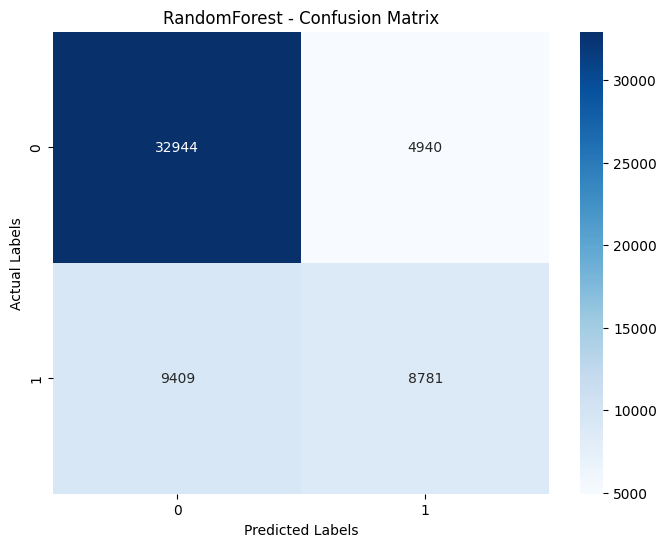

In [ ]:
# plot the confusion matrix of the tp, tn, fp, fn
confusion_matrix_plot(y_test_class, y_pred_rf_class, "RandomForest")

In [ ]:
# evaluate the random forest prediction
rf_metric_df = classification_metrics(y_test_class, y_pred_rf_class, "RandomForest")
rf_metric_df

,Accuracy,Precision,Recall,F1Score,CohenKappa,MCC
RandomForest,0.744106,0.733118,0.744106,0.733314,0.376375,0.383682


In [ ]:
# check the feature importance with the rf model
rf_imp = rf_class.feature_importances_
rf_imp_df = pd.DataFrame(rf_imp, index=x_train.columns, columns=["Gini-Importance"])
rf_imp_df.sort_values("Gini-Importance", ascending=False).index

Index(['Flight_Duration', 'Aicraft_age', 'Delay_Carrier', 'Delay_LastAircraft',
       'tavg', 'Delay_NAS', 'pres', 'wspd', 'wdir', 'Day', 'Month',
       'Day_Of_Week', 'prcp', 'DepTime_label_Evening', 'DepTime_label_Morning',
       'DepTime_label_Afternoon', 'Airline_Southwest Airlines Co.',
       'Distance_type', 'Delay_Weather', 'Airline_Delta Air Lines Inc',
       'Model_717', 'Model_757', 'Model_737 NG', 'Model_A320',
       'Manufacturer_CANADAIR REGIONAL JET', 'Model_A321', 'Model_CRJ',
       'Manufacturer_AIRBUS', 'Airline_Spirit Air Lines',
       'Manufacturer_BOEING', 'Airline_Endeavor Air',
       'Airline_United Air Lines Inc.', 'Airline_American Airlines Inc.',
       'Model_A319', 'Airline_Frontier Airlines Inc.', 'Holiday', 'Model_767',
       'Airline_JetBlue Airways', 'Airline_Skywest Airlines Inc.',
       'DepTime_label_Night', 'Model_A350', 'Airline_Republic Airways',
       'Manufacturer_EMBRAER', 'Airline_Alaska Airlines Inc.', 'Model_170/175',
       'Model

In [ ]:
# select top features based on their gini importance
new_features = [
    'Flight_Duration', 'Aicraft_age', 'Delay_Carrier', 'Delay_LastAircraft',
    'tavg', 'Delay_NAS', 'pres', 'wspd', 'wdir', 'Day', 'Month','Day_Of_Week',
    'prcp', 'DepTime_label_Evening', 'DepTime_label_Morning', 'DepTime_label_Afternoon',
]

# train the model again with only thes features and compare the performance
rf_class_new = train_classification_model("rf", x_train[new_features], y_train_class)

In [ ]:
# predict with trained random forest classifier that used the selected features
y_pred_rf_class_new = rf_class_new.predict(x_test[new_features])

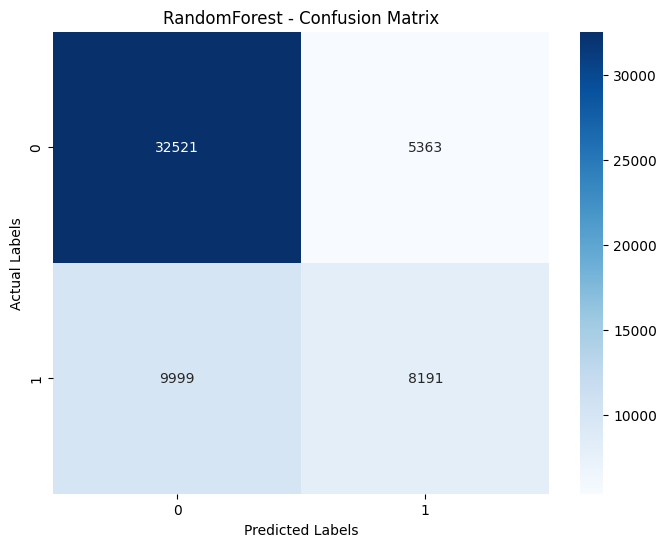

In [ ]:
# plot the confusion matrix of the tp, tn, fp, fn
confusion_matrix_plot(y_test_class, y_pred_rf_class_new, "RandomForest")

In [ ]:
# evaluate the random forest prediction
rf_metric_df_new = classification_metrics(y_test_class, y_pred_rf_class_new, "RandomForest")
rf_metric_df_new

,Accuracy,Precision,Recall,F1Score,CohenKappa,MCC
RandomForest,0.726041,0.71277,0.726041,0.713934,0.330642,0.337602


Retain using all the original features selected for subsequent models as the performance is still better.

#### Now work with the balanced Data

In [ ]:
# train the random forest model with the balanced data
rf_class_balanced = train_classification_model("rf", x_train_upsampled, y_train_upsampled)

In [ ]:
# predict the test data with trained random forest classifier
y_pred_rf_balanced = rf_class_balanced.predict(x_test)

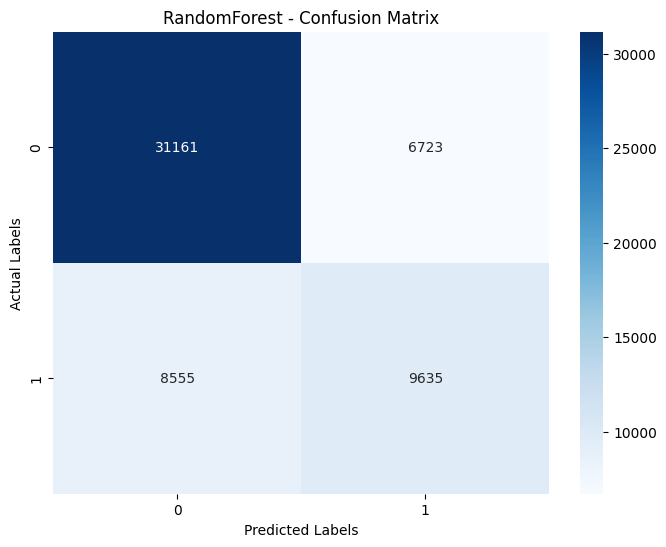

In [ ]:
# plot the confusion matrix of the tp, tn, fp, fn
confusion_matrix_plot(y_test_class, y_pred_rf_balanced, "RandomForest")

In [ ]:
# evaluate the random forest prediction
rf_metric_df_bal = classification_metrics(y_test_class, y_pred_rf_balanced, "RandomForest")
rf_metric_df_bal

,Accuracy,Precision,Recall,F1Score,CohenKappa,MCC
RandomForest,0.727539,0.721149,0.727539,0.723531,0.361692,0.362756


The model's performance on the unbalanced dataset is better than on the balanced dataset using smote to oversample. The best performance is the Random Forest model that used all the features originally selected with the unbalanced data.

### XGBoost Classification

#### Start with the Imbalanced Data

In [ ]:
# train the xgboost model with the imbalanced data
xgb_class= train_classification_model("xgboost", x_train, y_train_class)

In [ ]:
# predict the test data with trained xgboost classifier
y_pred_xgb = xgb_class.predict(x_test)

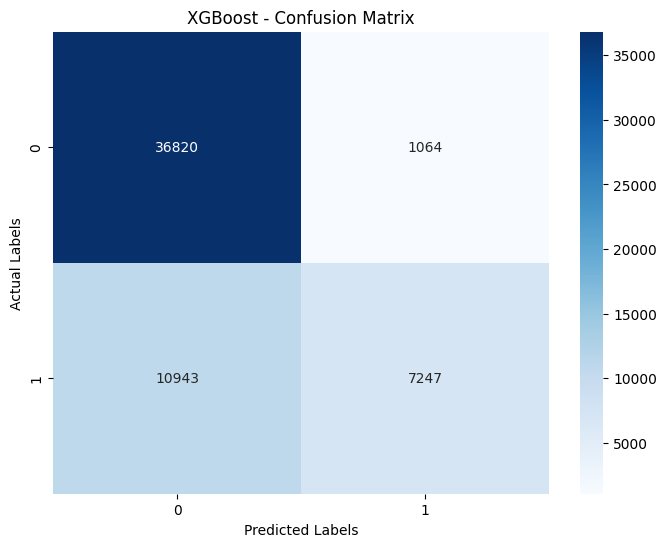

In [ ]:
# plot the confusion matrix of the tp, tn, fp, fn
confusion_matrix_plot(y_test_class, y_pred_xgb, "XGBoost")

In [ ]:
# evaluate the xgboost prediction
xgb_metric_df = classification_metrics(y_test_class, y_pred_xgb, "XGBoost")
xgb_metric_df

,Accuracy,Precision,Recall,F1Score,CohenKappa,MCC
XGBoost,0.785872,0.803682,0.785872,0.75831,0.431189,0.48792


The XGBoost classifier performs better than the Random Forest Classifier on the imbalanced data for all features

In [ ]:
# check the feature importance with the xgb model
xgb_imp = xgb_class.feature_importances_
xgb_imp_df = pd.DataFrame(xgb_imp, index=x_train.columns, columns=["Gini-Importance"])
xgb_imp_df.sort_values("Gini-Importance", ascending=False)

,Gini-Importance
Delay_Carrier,0.365460
Delay_LastAircraft,0.231001
Manufacturer_CANADAIR REGIONAL JET,0.060862
Airline_Southwest Airlines Co.,0.056760
Delay_Weather,0.045951
Model_717,0.024585
Manufacturer_AIRBUS,0.018282
Airline_Republic Airways,0.016705
Model_757,0.015134
DepTime_label_Morning,0.014008


Since the type of airline and model is distributed in terms of importance, do not drop any, although somw model feature do not ocntribute at all therefore maintain using all features

#### Use the Balanced Data for the XGBoost

In [ ]:
# train the xgboost model with the balanced data
xgb_balanced= train_classification_model("xgboost", x_train_upsampled, y_train_upsampled)

In [ ]:
# predict the test data with trained xgboost classifier
y_pred_xgb_bal = xgb_balanced.predict(x_test)

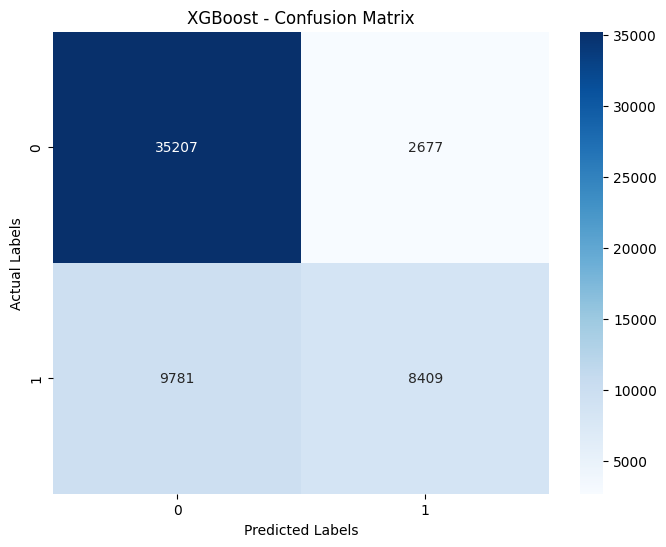

In [ ]:
# plot the confusion matrix of the tp, tn, fp, fn
confusion_matrix_plot(y_test_class, y_pred_xgb_bal, "XGBoost")

In [ ]:
# evaluate the xgboost prediction
xgb_bal_metric_df = classification_metrics(y_test_class, y_pred_xgb_bal, "XGBoost")
xgb_bal_metric_df

,Accuracy,Precision,Recall,F1Score,CohenKappa,MCC
XGBoost,0.777829,0.774781,0.777829,0.760396,0.43587,0.460339


The XGBoost Model also performs slightly better with the unbalanced data when comparing all the metrics

### AdaBoost Classification

#### Start with the Imbalanced Data

In [ ]:
# train the adaboost model with the imbalanced data
ada_class= train_classification_model("adaboost", x_train, y_train_class)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:
# predict the test data with trained adaboost classifier
y_pred_ada_class = ada_class.predict(x_test)

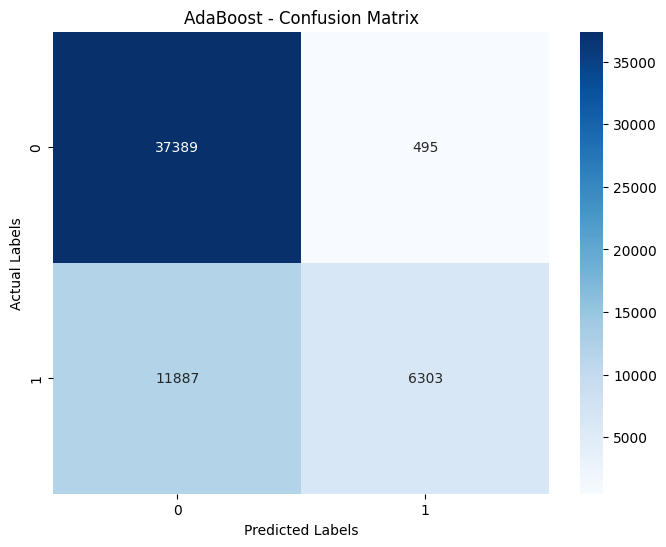

In [ ]:
# plot the confusion matrix of the tp, tn, fp, fn
confusion_matrix_plot(y_test_class, y_pred_ada_class, "AdaBoost")

In [ ]:
# evaluate the adaboost prediction
ada_metric_df = classification_metrics(y_test_class, y_pred_ada_class, "AdaBoost")
ada_metric_df

,Accuracy,Precision,Recall,F1Score,CohenKappa,MCC
AdaBoost,0.779185,0.8134,0.779185,0.74328,0.398276,0.478253


The Xgboost does better than the Adaboost when comparing the metrics

In [ ]:
# check the feature importance with the adaboost model
ada_imp = ada_class.feature_importances_
ada_imp_df = pd.DataFrame(ada_imp, index=x_train.columns, columns=["Gini-Importance"])
ada_imp_df.sort_values("Gini-Importance", ascending=False).index

Index(['wspd', 'Delay_NAS', 'Delay_Carrier', 'Delay_LastAircraft',
       'Flight_Duration', 'tavg', 'prcp', 'Model_757', 'Month', 'Day_Of_Week',
       'Airline_Southwest Airlines Co.', 'Airline_Republic Airways',
       'Model_737 NG', 'Model_767', 'Model_A319', 'Model_717',
       'Manufacturer_CANADAIR REGIONAL JET', 'DepTime_label_Morning',
       'DepTime_label_Evening', 'Airline_Spirit Air Lines', 'Model_A350',
       'Airline_Skywest Airlines Inc.', 'Distance_type', 'Day',
       'Delay_Weather', 'Airline_Delta Air Lines Inc', 'Delay_Security',
       'Airline_American Airlines Inc.', 'Aicraft_age',
       'Airline_JetBlue Airways', 'Model_A330', 'Model_A321', 'Model_A320',
       'Model_A300', 'Model_A220', 'wdir', 'Model_737 NG/MAX', 'pres',
       'Model_737', 'Model_170/175', 'Model_190/195', 'Airline_PSA Airlines',
       'Manufacturer_EMBRAER', 'Holiday', 'Manufacturer_BOEING',
       'Manufacturer_AIRBUS', 'DepTime_label_Night',
       'Airline_Alaska Airlines Inc.', 'De

A lot of feauture do not contribute to the model's performance. Select a few that do.

In [ ]:
new_ada_features = ['wspd', 'Delay_NAS', 'Delay_Carrier', 'Delay_LastAircraft','Flight_Duration', 'tavg', 'prcp', 'Month', 'Day_Of_Week']

In [ ]:
# train with the new features
ada_class_new= train_classification_model("adaboost", x_train[new_ada_features], y_train_class)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:
# predict the test data with trained adaboost classifier
y_pred_ada_class_new = ada_class_new.predict(x_test[new_ada_features])

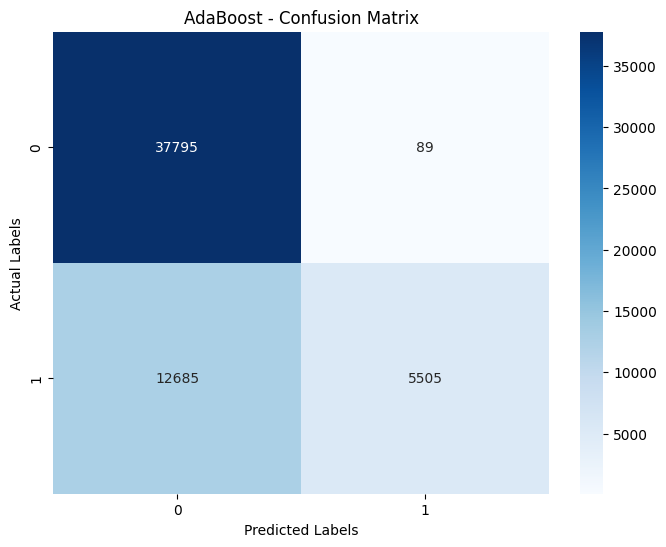

In [ ]:
# plot the confusion matrix of the tp, tn, fp, fn
confusion_matrix_plot(y_test_class, y_pred_ada_class_new, "AdaBoost")

In [ ]:
# evaluate the adaboost prediction
ada_new_metric_df = classification_metrics(y_test_class, y_pred_ada_class_new, "AdaBoost")
ada_new_metric_df

,Accuracy,Precision,Recall,F1Score,CohenKappa,MCC
AdaBoost,0.772194,0.825067,0.772194,0.728107,0.366202,0.469098


Retain using the orignal features

#### Use the AdaBoost Classifier with the Balanced Data

In [ ]:
# train the adaboost with the balanced data
ada_balanced= train_classification_model("adaboost", x_train_upsampled, y_train_upsampled)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:
# predict the test data with trained adaboost classifier
y_pred_ada_balanced = ada_balanced.predict(x_test)

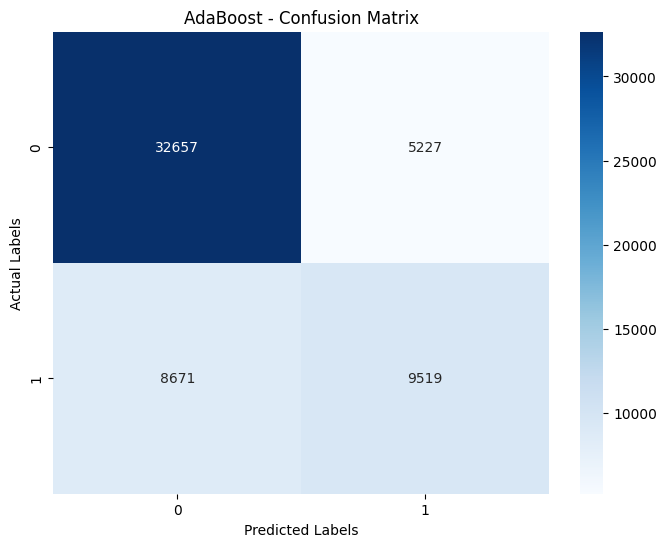

In [ ]:
# plot the confusion matrix of the tp, tn, fp, fn
confusion_matrix_plot(y_test_class, y_pred_ada_balanced, "AdaBoost")

In [ ]:
# evaluate the adaboost prediction
ada_bal_metric_df = classification_metrics(y_test_class, y_pred_ada_balanced, "AdaBoost")
ada_bal_metric_df

,Accuracy,Precision,Recall,F1Score,CohenKappa,MCC
AdaBoost,0.752149,0.743264,0.752149,0.744579,0.405281,0.409755


Using the Balanced data improved the CohenKappa score and the F1score. Although other metrics were better for the imbalanced data. The Adaboost with the balanced data seem like a better fit

### CNN Classification

#### Start with the Imbalanced Data

In [ ]:
# train the cnn model with the imbalanced data
cnn_class = train_classification_model("cnn", x_train, y_train_class)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7532 - loss: 0.5228
Epoch 2/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7763 - loss: 0.4853
Epoch 3/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7776 - loss: 0.4800
Epoch 4/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7786 - loss: 0.4780
Epoch 5/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7802 - loss: 0.4749
Epoch 6/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7813 - loss: 0.4737
Epoch 7/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7832 - loss: 0.4715
Epoch 8/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7807 - loss: 0.4736
Epoch 9/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7824 - loss: 0.4710
Epoch 10/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7814 - loss: 0.4721


In [ ]:
# predict the test data with trained cnn classifier
x_test_reshaped = np.expand_dims(x_test, axis=1)
y_pred_cnn_class = cnn_class.predict(x_test_reshaped)

1753/1753 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


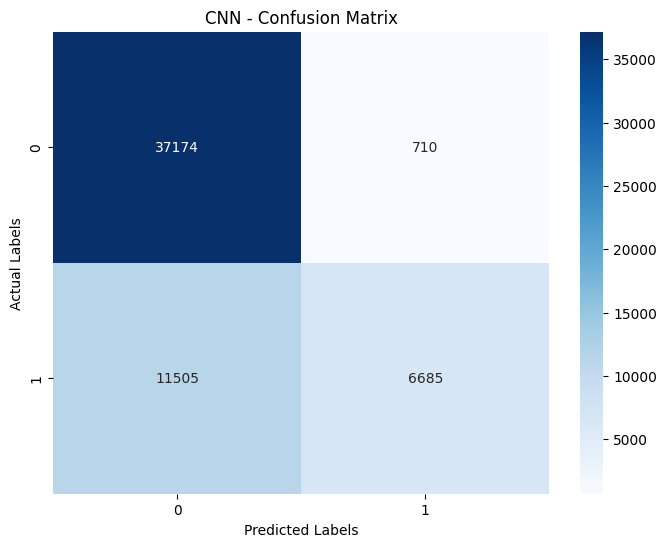

In [ ]:
# flatten the predictions from the cnn classification
y_pred_cnn_class = y_pred_cnn_class.flatten()
# update the cnn predictions to binary
y_pred_cnn_class = (y_pred_cnn_class >= 0.5).astype(int)
# plot the confusion matrix of the tp, tn, fp, fn
confusion_matrix_plot(y_test_class, y_pred_cnn_class, "CNN")

In [ ]:
# evaluate the ann prediction
cnn_class_metric_df = classification_metrics(y_test_class, y_pred_cnn_class, "CNN")
cnn_class_metric_df

,Accuracy,Precision,Recall,F1Score,CohenKappa,MCC
CNN,0.782163,0.809179,0.782163,0.74979,0.41238,0.482549


The CNN model does well following after Xgboost at predict the delay tag. Finetuning tecniques can improve the performance

#### Use cyclical encoding on the month, week and day columns

In [ ]:
# create a function to take in a dataframe and the columns to encode
def cyclical_encoding(df, columns):
  # create a copy of the dataframe
  df_copy = df.copy()
  for column in columns:
    if column == "Month":
      df_copy['Month_Sine'] = np.sin(2 * np.pi * df_copy['Month'] / 12)
      df_copy['Month_Cosine'] = np.cos(2 * np.pi * df_copy['Month'] / 12)

    elif column == "Day_Of_Week":
      df_copy['Weekday_Sine'] = np.sin(2 * np.pi * df_copy['Day_Of_Week'] / 7)
      df_copy['Weekday_Cosine'] = np.cos(2 * np.pi * df_copy['Day_Of_Week'] / 7)

    elif column == "Day":
      df_copy['Day_Sine'] = np.sin(2 * np.pi * df_copy['Day'] / 31)
      df_copy['Day_Cosine'] = np.cos(2 * np.pi * df_copy['Day'] / 31)


    # drop the columns for the data
    df_copy.drop(columns, axis=1, inplace=True)

    return df_copy


In [ ]:
# select the temporal columns
columns_to_encode = ["Day", "Day_Of_Week", "Month"]

# create xtrain to be encooded
x_train_encoding = cyclical_encoding(x_train, columns_to_encode)

# create a copy of xtest to be encooded
x_test_encoding = cyclical_encoding(x_test, columns_to_encode)


In [ ]:
# train the cnn model with the temporal data encoded
cnn_class_encode = train_classification_model("cnn", x_train_encoding, y_train_class)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7591 - loss: 0.5114
Epoch 2/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7811 - loss: 0.4776
Epoch 3/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7808 - loss: 0.4764
Epoch 4/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7796 - loss: 0.4765
Epoch 5/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7810 - loss: 0.4758
Epoch 6/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7820 - loss: 0.4742
Epoch 7/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7813 - loss: 0.4748
Epoch 8/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7812 - loss: 0.4740
Epoch 9/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7817 - loss: 0.4736
Epoch 10/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7825 - loss: 0.4714


In [ ]:
# predict the test data with trained cnn classifier
x_test_reshaped = np.expand_dims(x_test_encoding, axis=1)
y_pred_cnn_encode = cnn_class_encode.predict(x_test_reshaped)

In [ ]:
# flatten the predictions from the cnn classification
y_pred_cnn_encode = y_pred_cnn_encode.flatten()
# update the cnn predictions to binary
y_pred_cnn_encode = (y_pred_cnn_encode >= 0.5).astype(int)
# plot the confusion matrix of the tp, tn, fp, fn
confusion_matrix_plot(y_test_class, y_pred_cnn_encode, "CNN")

In [ ]:
# evaluate the cnn prediction
cnn_class_metric_df_1 = classification_metrics(y_test_class, y_pred_cnn_encode, "CNN")
cnn_class_metric_df_1

The CNN model is better without cyclical encoding.

#### Use the imbalanced data

In [ ]:
# train the cnn with the balanced data
cnn_class_balanced = train_classification_model("cnn", x_train_upsampled, y_train_upsampled)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6865 - loss: 0.5587
Epoch 2/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7378 - loss: 0.4920
Epoch 3/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7395 - loss: 0.4848
Epoch 4/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7429 - loss: 0.4772
Epoch 5/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7460 - loss: 0.4735
Epoch 6/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7479 - loss: 0.4705
Epoch 7/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7490 - loss: 0.4683
Epoch 8/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7505 - loss: 0.4666
Epoch 9/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7521 - loss: 0.4648
Epoch 10/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7512 - loss: 0.4656


In [ ]:
# predict the test data with trained cnn classifier
x_test_reshaped = np.expand_dims(x_test, axis=1)
y_pred_cnn_balanced = cnn_class_balanced.predict(x_test_reshaped)

1753/1753 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


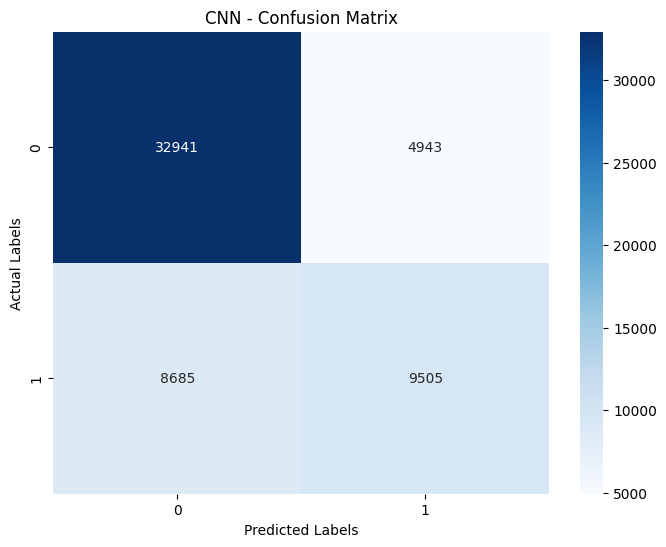

In [ ]:
# flatten the predictions from the cnn classification
y_pred_cnn_balanced = y_pred_cnn_balanced.flatten()
# update the cnn predictions to binary
y_pred_cnn_balanced = (y_pred_cnn_balanced >= 0.5).astype(int)
# plot the confusion matrix of the tp, tn, fp, fn
confusion_matrix_plot(y_test_class, y_pred_cnn_balanced, "CNN")

In [ ]:
# evaluate the cnn prediction
cnn_class_metric_df_2 = classification_metrics(y_test_class, y_pred_cnn_encode, "CNN")
cnn_class_metric_df_2

,Accuracy,Precision,Recall,F1Score,CohenKappa,MCC
CNN,0.778667,0.81525,0.778667,0.741823,0.395226,0.478165


The CNN model does best on the imbalanced data

### LSTM Classification

#### Imbalanced Data

In [ ]:
# train the lstm with the imbalanced data
lstm_class = train_classification_model("lstm", x_train, y_train_class)

In [ ]:
# predict the test data with trained lstm classifier
x_test_reshaped = np.expand_dims(x_test, axis=1)
y_pred_lstm_class = lstm_class.predict(x_test_reshaped)

1753/1753 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


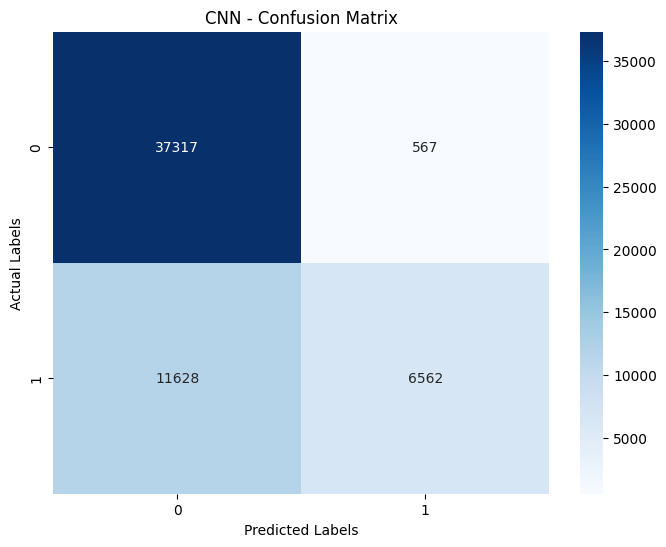

In [ ]:
# flatten the predictions from the lstm classification
y_pred_lstm_class = y_pred_lstm_class.flatten()
# update the lstm predictions to binary
y_pred_lstm_class = (y_pred_lstm_class >= 0.5).astype(int)
# plot the confusion matrix of the tp, tn, fp, fn
confusion_matrix_plot(y_test_class, y_pred_lstm_class, "CNN")

In [ ]:
# evaluate the cnn prediction
lstm_class_metric_df = classification_metrics(y_test_class, y_pred_lstm_class, "LSTM")
lstm_class_metric_df

,Accuracy,Precision,Recall,F1Score,CohenKappa,MCC
LSTM,0.78252,0.813694,0.78252,0.748867,0.410693,0.485933


#### Use cyclical encoding on the month, week and day columns

In [ ]:
# train the lstm model with the temporal data encoded
lstm_class_encode = train_classification_model("lstm", x_train_encoding, y_train_class)

Epoch 1/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7558 - loss: 0.5202
Epoch 2/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7798 - loss: 0.4792
Epoch 3/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7802 - loss: 0.4779
Epoch 4/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7809 - loss: 0.4760
Epoch 5/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7804 - loss: 0.4754
Epoch 6/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7797 - loss: 0.4764
Epoch 7/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7818 - loss: 0.4737
Epoch 8/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7808 - loss: 0.4747
Epoch 9/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7804 - loss: 0.4751
Epoch 10/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7811 - loss: 0.4722


In [148]:
# predict the test data with trained lstm classifier
x_test_reshaped = np.expand_dims(x_test_encoding, axis=1)
y_pred_lstm_encode = lstm_class_encode.predict(x_test_reshaped)

1753/1753 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


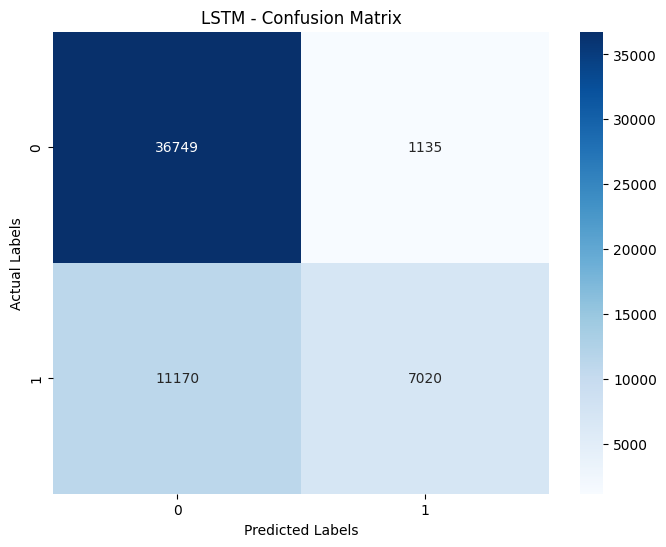

In [149]:
# flatten the predictions from the lstm classification
y_pred_lstm_encode = y_pred_lstm_encode.flatten()
# update the lstm predictions to binary
y_pred_lstm_encode = (y_pred_lstm_encode >= 0.5).astype(int)
# plot the confusion matrix of the tp, tn, fp, fn
confusion_matrix_plot(y_test_class, y_pred_lstm_encode, "LSTM")

In [150]:
# evaluate the lstm prediction
lstm_class_metric_df_1 = classification_metrics(y_test_class, y_pred_lstm_encode, "LSTM")
lstm_class_metric_df_1

,Accuracy,Precision,Recall,F1Score,CohenKappa,MCC
LSTM,0.780558,0.797366,0.780558,0.751597,0.415555,0.472702


#### Balanced Data

In [151]:
# train the lstm with the balanced data
lstm_class_balanced = train_classification_model("lstm", x_train_upsampled, y_train_upsampled)

Epoch 1/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6908 - loss: 0.5547
Epoch 2/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7431 - loss: 0.4852
Epoch 3/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.7451 - loss: 0.4781
Epoch 4/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7470 - loss: 0.4744
Epoch 5/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7470 - loss: 0.4728
Epoch 6/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7489 - loss: 0.4712
Epoch 7/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.7494 - loss: 0.4694
Epoch 8/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.7502 - loss: 0.4675
Epoch 9/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.7518 - loss: 0.4661
Epoch 10/10
4731/4731 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.7524 - loss: 0.4647


In [152]:
# predict the test data with trained lstm classifier
x_test_reshaped = np.expand_dims(x_test, axis=1)
y_pred_lstm_balanced = lstm_class_balanced.predict(x_test_reshaped)

1753/1753 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


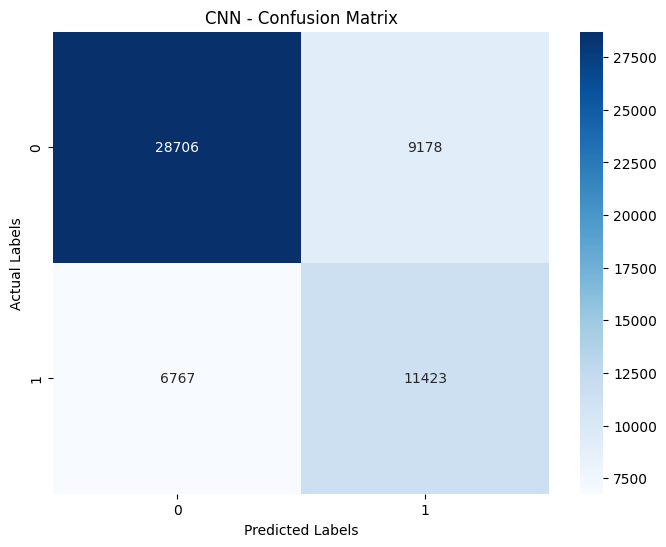

In [153]:
# flatten the predictions from the lstm classification
y_pred_lstm_balanced = y_pred_lstm_balanced.flatten()
# update the lstm predictions to binary
y_pred_lstm_balanced = (y_pred_lstm_balanced >= 0.5).astype(int)
# plot the confusion matrix of the tp, tn, fp, fn
confusion_matrix_plot(y_test_class, y_pred_lstm_balanced, "CNN")

### Stack the best performing traditional classification model with the deep learning models for the unbalanced data

In [154]:
# use the previously trained xgboost on the imbalanced train data to predict on the train now data instead of test
y_pred_xgb_1 = xgb_class.predict(x_train)

# use the previously trained cnn on the imbalanced train data to predict on the train now data instead of test
x_train_reshaped = np.expand_dims(x_train, axis=1)
y_pred_cnn_1 = cnn_class.predict(x_train_reshaped)

# use the previously trained lstm on the imbalanced train data to predict on the train now data instead of test
y_pred_lstm_1 = lstm_class.predict(x_train_reshaped)

7010/7010 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
7010/7010 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


In [155]:
# flatten the cnn and lstm predictions
y_pred_cnn_flatten = y_pred_cnn_1.flatten()
y_pred_lstm_flatten = y_pred_lstm_1.flatten()

In [156]:
# stack the predictions of the cnn, lstm, and xgboost for the train data
stacked_data_train = np.column_stack((y_pred_cnn_flatten, y_pred_lstm_flatten, y_pred_xgb_1))

# create the metaleaner model as the AdaBoost model
meta_learner = AdaBoostClassifier()
meta_learner.fit(stacked_data_train, y_train_class)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier()

In [157]:
# stack the predictions of the cnn, lstm, and xgboost for the test
stacked_data_test = np.column_stack((y_pred_cnn_class, y_pred_lstm_class, y_pred_xgb))

In [158]:
# predict with the Adaboost from the stack
y_pred_ada_stack = meta_learner.predict(stacked_data_test)

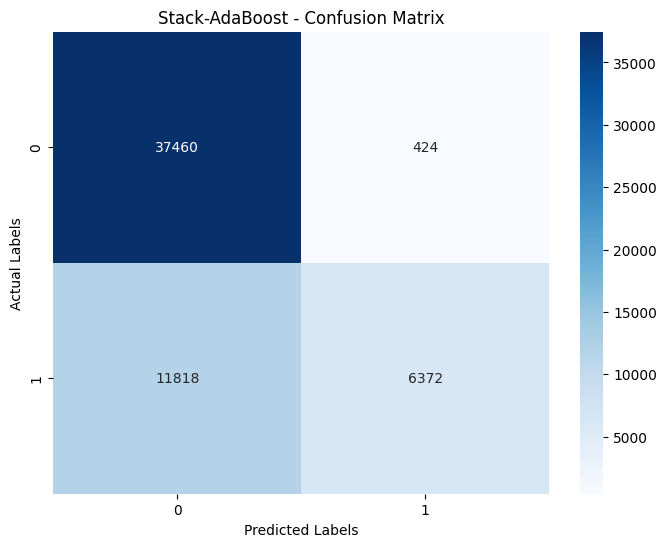

In [159]:
# plot the confusion matrix of the AdaBoostClassifier from stacking
confusion_matrix_plot(y_test_class, y_pred_ada_stack, "Stack-AdaBoost")

In [160]:
# evaluate the lstm prediction
ada_stacked_metric_df = classification_metrics(y_test_class, y_pred_ada_stack, "Stacked-AdaBoost")
ada_stacked_metric_df

,Accuracy,Precision,Recall,F1Score,CohenKappa,MCC
Stacked-AdaBoost,0.781681,0.817735,0.781681,0.746173,0.40506,0.486443


                  Accuracy  Precision    Recall   F1Score  CohenKappa  \
RandomForest      0.744106   0.733118  0.744106  0.733314    0.376375   
XGBoost           0.785872   0.803682  0.785872  0.758310    0.431189   
AdaBoost          0.779185   0.813400  0.779185  0.743280    0.398276   
CNN               0.782163   0.809179  0.782163  0.749790    0.412380   
LSTM              0.782520   0.813694  0.782520  0.748867    0.410693   
Stacked-AdaBoost  0.781681   0.817735  0.781681  0.746173    0.405060   

                       MCC  
RandomForest      0.383682  
XGBoost           0.487920  
AdaBoost          0.478253  
CNN               0.482549  
LSTM              0.485933  
Stacked-AdaBoost  0.486443  


<Figure size 2000x1200 with 0 Axes>

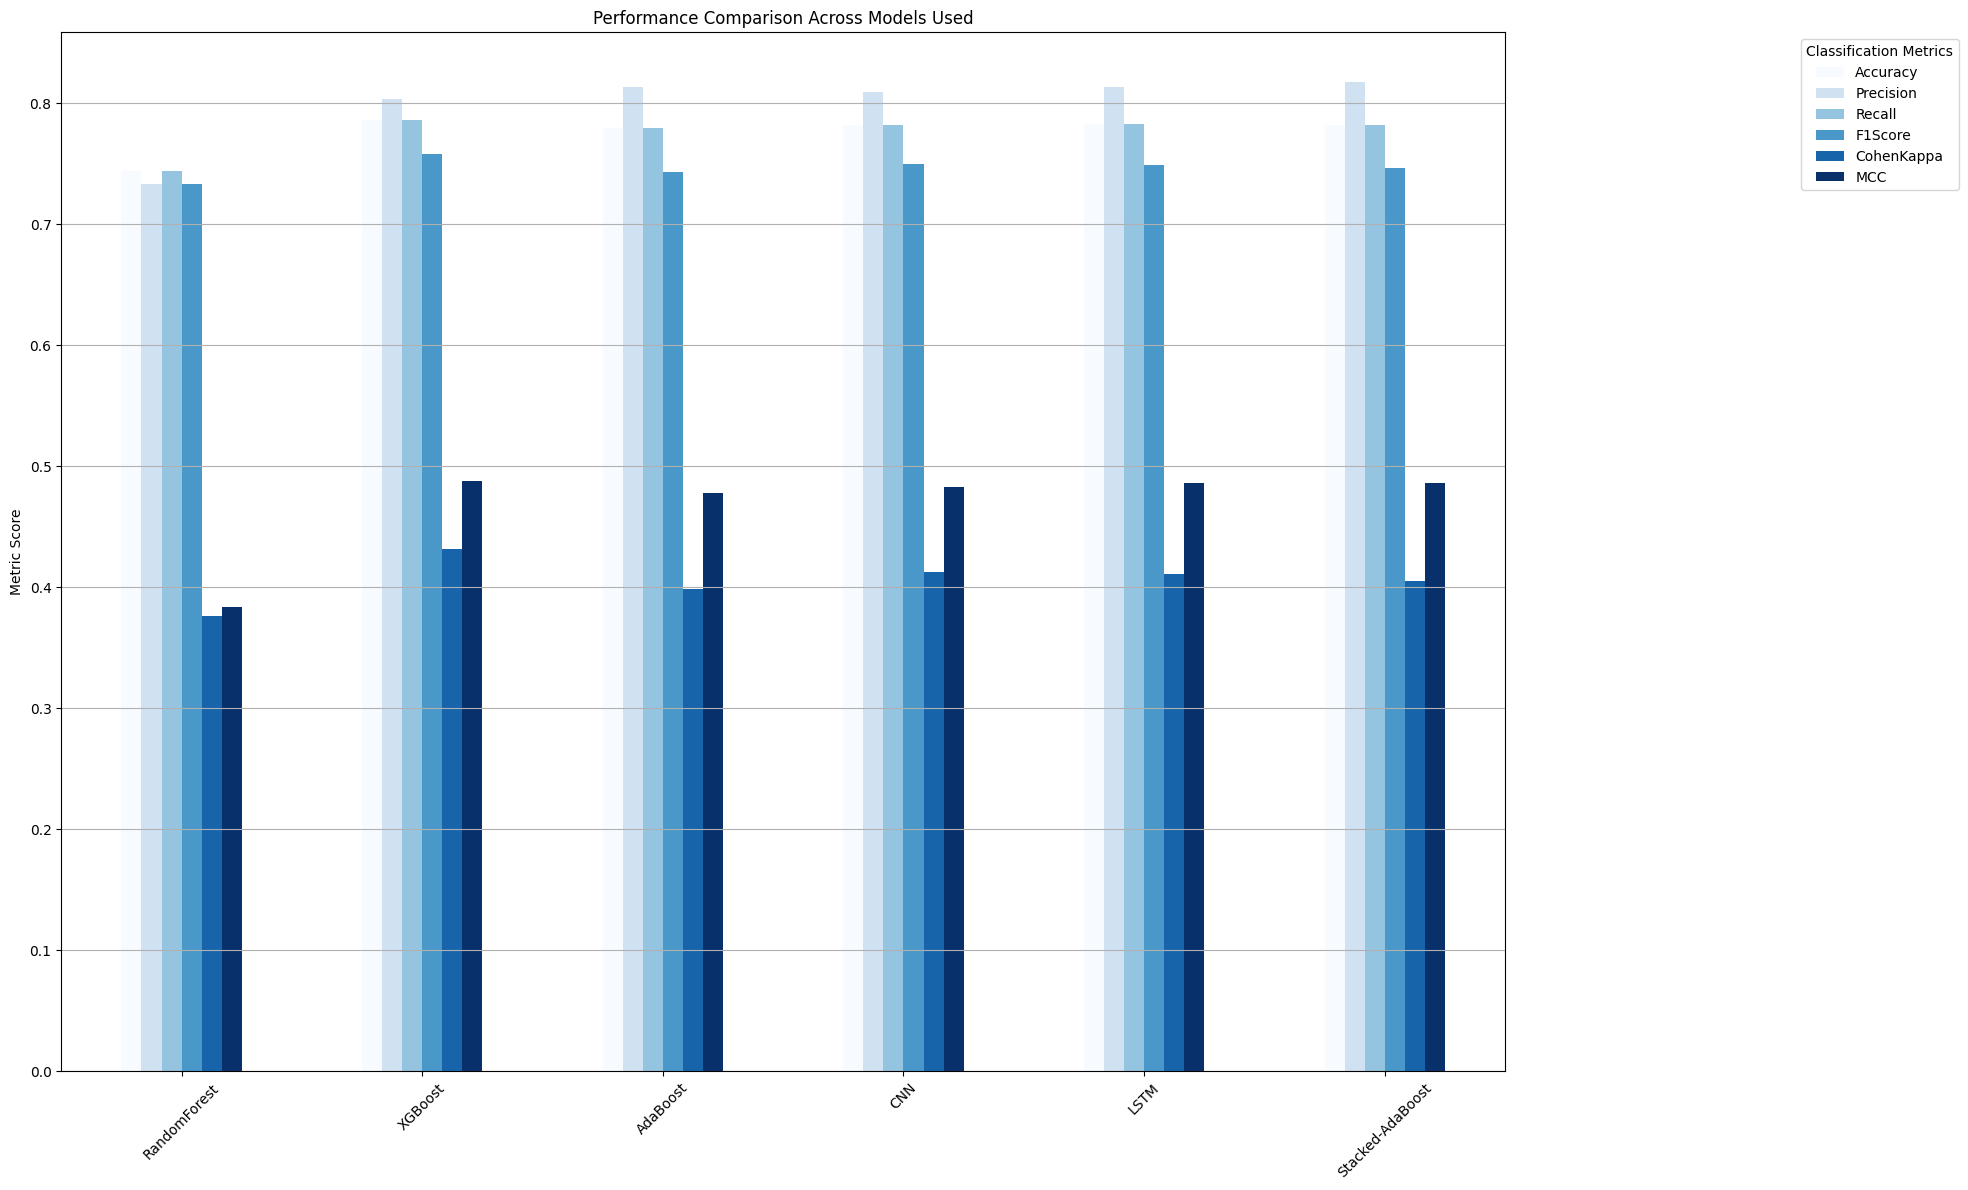

In [170]:
plot_classification_metrics(rf_metric_df, xgb_metric_df, ada_metric_df, cnn_class_metric_df, lstm_class_metric_df, ada_stacked_metric_df)

### Regression models

#### Random Forest Regression

In [171]:
# train a random forest regressor with the train data
rf_reg = train_regression_model("rf", x_train, y_train_reg)

In [172]:
# use the train rf_reg model to predict the delay in minutes with the test data
y_pred_rf_reg = rf_reg.predict(x_test)

In [176]:
# function to return a dataframe of the metrics mae, mse, r2_Score
def eval_reg_models(y_test, y_pred, model):
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  eval_df = pd.DataFrame({
      "MAE" : mae,
      "MSE" : mse,
      "R2" : r2
  }, index=[model])
  return eval_df

In [178]:
rf_reg_metric_df = eval_reg_models(y_test_reg, y_pred_rf_reg, "RandomForest")
rf_reg_metric_df

,MAE,MSE,R2
RandomForest,3.430874,58.884442,0.936859


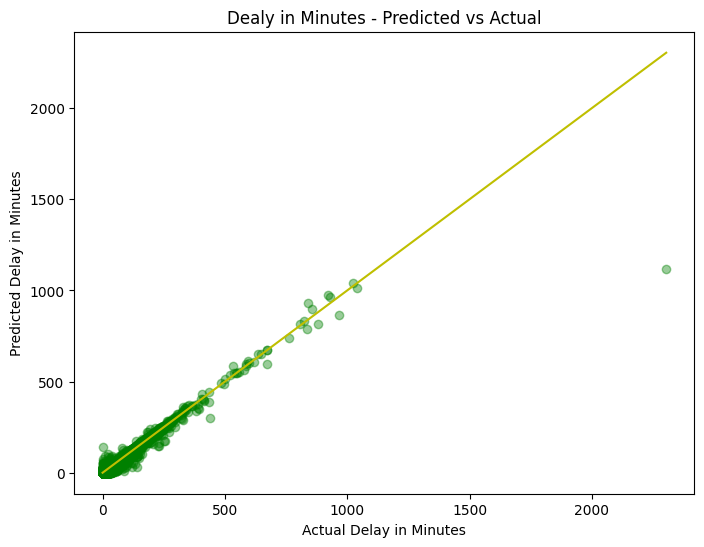

In [188]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_rf_reg, color="g", alpha=0.4)
y_range = [y_test_reg.min(), y_test_reg.max()]
plt.plot(y_range, y_range, 'y-')
plt.xlabel('Actual Delay in Minutes')
plt.ylabel('Predicted Delay in Minutes')
plt.title('Dealy in Minutes - Predicted vs Actual')
plt.show()

#### Xgboost Regression

In [187]:
# train a xgboost regressor with the train data
xgb_reg = train_regression_model("xgboost", x_train, y_train_reg)

In [189]:
# use the train xgb_reg model to predict the delay in minutes with the test data
y_pred_xgb_reg = xgb_reg.predict(x_test)

In [195]:
xgb_reg_metric_df = eval_reg_models(y_test_reg, y_pred_xgb_reg, "XGBoost")
xgb_reg_metric_df

,MAE,MSE,R2
XGBoost,3.341706,81.058627,0.913082


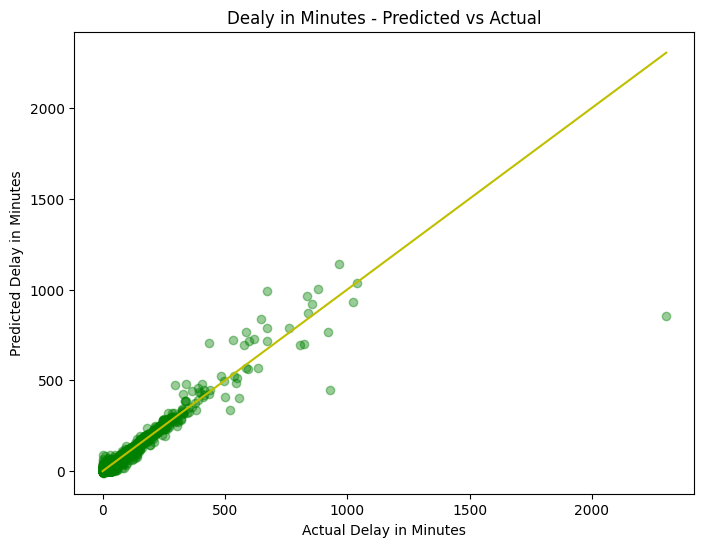

In [191]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_xgb_reg, color="g", alpha=0.4)
y_range = [y_test_reg.min(), y_test_reg.max()]
plt.plot(y_range, y_range, 'y-')
plt.xlabel('Actual Delay in Minutes')
plt.ylabel('Predicted Delay in Minutes')
plt.title('Dealy in Minutes - Predicted vs Actual')
plt.show()

#### AdaBoost Regression

In [192]:
# train a adaboost regressor with the train data
ada_reg = train_regression_model("adaboost", x_train, y_train_reg)

In [193]:
# use the train ada_reg model to predict the delay in minutes with the test data
y_pred_ada_reg = ada_reg.predict(x_test)

In [196]:
ada_reg_metric_df = eval_reg_models(y_test_reg, y_pred_ada_reg, "AdaBoost")
ada_reg_metric_df

,MAE,MSE,R2
AdaBoost,159.251059,25748.979913,-26.61011


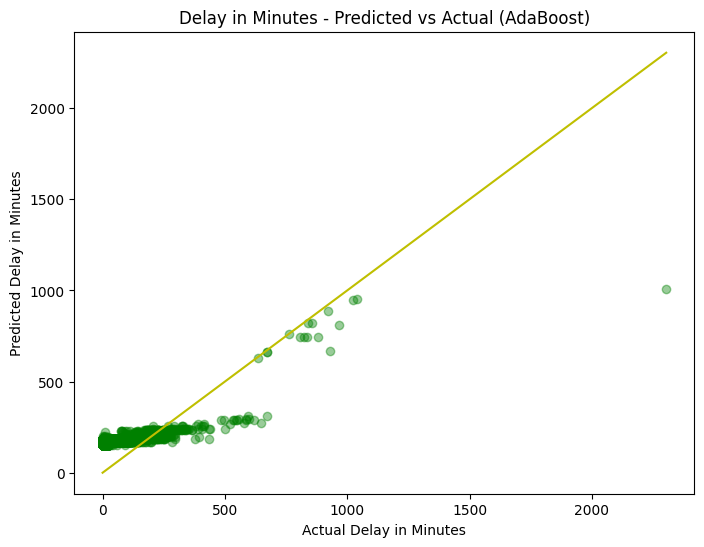

In [197]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_ada_reg, color="g", alpha=0.4)
y_range = [y_test_reg.min(), y_test_reg.max()]
plt.plot(y_range, y_range, 'y-')
plt.xlabel('Actual Delay in Minutes')
plt.ylabel('Predicted Delay in Minutes')
plt.title('Delay in Minutes - Predicted vs Actual (AdaBoost)')
plt.show()

#### CNN Regression

In [198]:
# train a cnn regression model with the train data
cnn_reg = train_regression_model("cnn", x_train, y_train_reg)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 4.3933
Epoch 2/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.5625
Epoch 3/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 2.4974
Epoch 4/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 2.4231
Epoch 5/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.3940
Epoch 6/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 2.3745
Epoch 7/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 2.3677
Epoch 8/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 2.3359
Epoch 9/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 2.3441
Epoch 10/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 2.3523


In [200]:
# use the trained cnn model to predict the delay in minutes with the test data
x_test_reshaped = np.expand_dims(x_test, axis=1)
y_pred_cnn_reg = cnn_reg.predict(x_test_reshaped)
y_pred_cnn_reg = y_pred_cnn_reg.flatten()

1753/1753 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [201]:
cnn_reg_metric_df = eval_reg_models(y_test_reg, y_pred_cnn_reg, "CNN")
cnn_reg_metric_df

,MAE,MSE,R2
CNN,2.346284,32.934923,0.964685


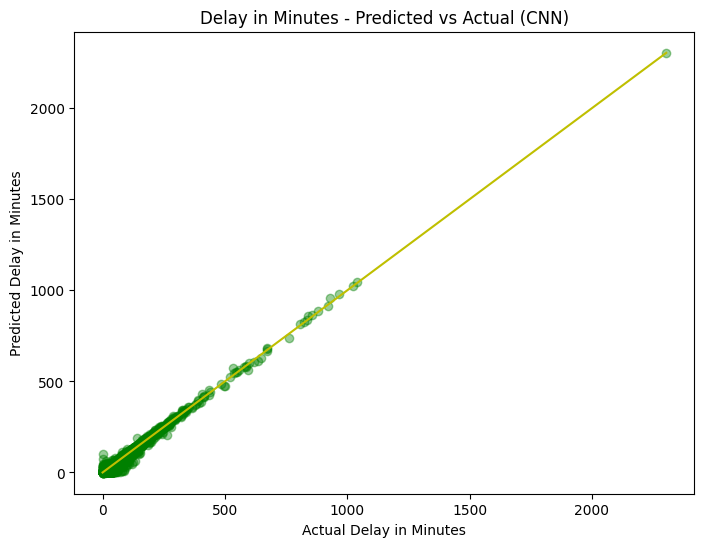

In [202]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_cnn_reg, color="g", alpha=0.4)
y_range = [y_test_reg.min(), y_test_reg.max()]
plt.plot(y_range, y_range, 'y-')
plt.xlabel('Actual Delay in Minutes')
plt.ylabel('Predicted Delay in Minutes')
plt.title('Delay in Minutes - Predicted vs Actual (CNN)')
plt.show()

#### LSTM Regression

In [203]:
# train a lstm regression model with the train data
lstm_reg = train_regression_model("lstm", x_train, y_train_reg)

Epoch 1/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 5.9609
Epoch 2/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 4.0911
Epoch 3/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 3.6261
Epoch 4/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 3.4259
Epoch 5/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 3.1880
Epoch 6/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 3.0523
Epoch 7/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 3.0947
Epoch 8/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 2.9276
Epoch 9/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 2.8744
Epoch 10/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 2.8557


In [205]:
# use the trained lstm model to predict the delay in minutes with the test data
x_test_reshaped = np.expand_dims(x_test, axis=1)
y_pred_lstm_reg = lstm_reg.predict(x_test_reshaped)
y_pred_lstm_reg = y_pred_lstm_reg.flatten()

1753/1753 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [207]:
lstm_reg_metric_df = eval_reg_models(y_test_reg, y_pred_lstm_reg, "LSTM")
lstm_reg_metric_df

,MAE,MSE,R2
LSTM,2.817992,243.582201,0.738812


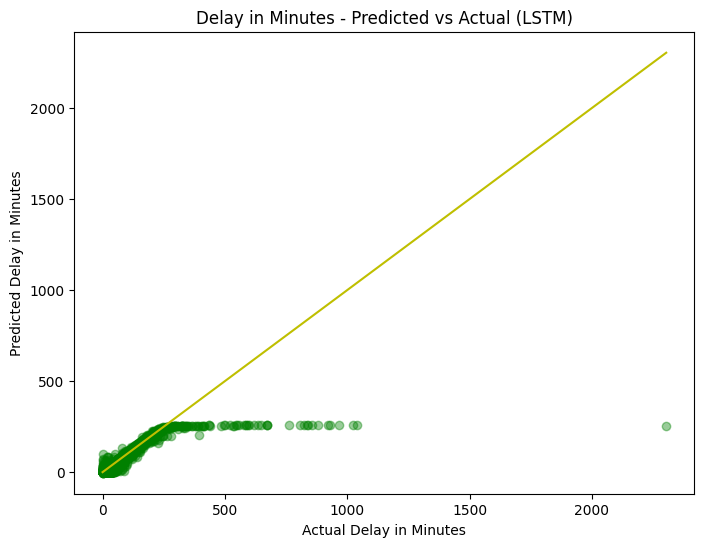

In [206]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_lstm_reg, color="g", alpha=0.4)
y_range = [y_test_reg.min(), y_test_reg.max()]
plt.plot(y_range, y_range, 'y-')
plt.xlabel('Actual Delay in Minutes')
plt.ylabel('Predicted Delay in Minutes')
plt.title('Delay in Minutes - Predicted vs Actual (LSTM)')
plt.show()

#### Stacked-Ada Boost Regression

In [208]:
# use the previously trained xgboost on the train data for regression
y_pred_xgb_2 = xgb_reg.predict(x_train)

# use the previously trained cnn on the train data for regression
x_train_reshaped = np.expand_dims(x_train, axis=1)
y_pred_cnn_2 = cnn_reg.predict(x_train_reshaped)

# use the previously trained lstm on the train data for regression
y_pred_lstm_2 = lstm_reg.predict(x_train_reshaped)

7010/7010 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
7010/7010 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


In [209]:
# flatten the cnn and lstm predictiction
y_pred_cnn_flatten_1 = y_pred_cnn_2.flatten()
y_pred_lstm_flatten_1 = y_pred_lstm_2.flatten()

In [210]:
# stack the predictions of the cnn, lstm, and xgboost for the train data
stacked_data_train = np.column_stack((y_pred_cnn_flatten, y_pred_lstm_flatten, y_pred_xgb_1))
stacked_data_test = np.column_stack((y_pred_cnn_reg, y_pred_lstm_reg, y_pred_xgb_reg))

# create the metaleaner model as the AdaBoost model
meta_learner = AdaBoostRegressor()
meta_learner.fit(stacked_data_train, y_train_reg)

AdaBoostRegressor()

In [211]:
# predict with the Adaboost from the stack
y_pred_ada_stack_reg = meta_learner.predict(stacked_data_test)

In [212]:
ada_stack_reg_metric_df = eval_reg_models(y_test_reg, y_pred_ada_stack_reg, "AdaStacked")
ada_stack_reg_metric_df

,MAE,MSE,R2
AdaStacked,30.461474,6320.566617,-5.777416


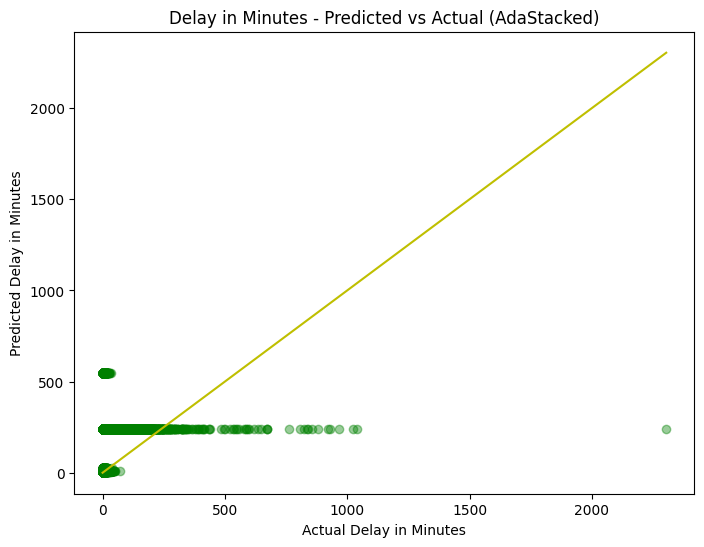

In [213]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_ada_stack_reg, color="g", alpha=0.4)
y_range = [y_test_reg.min(), y_test_reg.max()]
plt.plot(y_range, y_range, 'y-')
plt.xlabel('Actual Delay in Minutes')
plt.ylabel('Predicted Delay in Minutes')
plt.title('Delay in Minutes - Predicted vs Actual (AdaStacked)')
plt.show()

In [215]:
# show the dataframe will the metrics for each model combined
pd.concat([rf_reg_metric_df, xgb_reg_metric_df, ada_reg_metric_df, cnn_reg_metric_df, lstm_reg_metric_df, ada_stack_reg_metric_df])

,MAE,MSE,R2
RandomForest,3.430874,58.884442,0.936859
XGBoost,3.341706,81.058627,0.913082
AdaBoost,159.251059,25748.979913,-26.610110
CNN,2.346284,32.934923,0.964685
LSTM,2.817992,243.582201,0.738812
AdaStacked,30.461474,6320.566617,-5.777416
